# utils for Symmetry Projected Edge Correlation

In [1]:
from parse import parse
import numpy as np
import matplotlib.pyplot as plt
import fnmatch
import os
import pickle

def parseLine(line, obs, id):
    # print(line)
    r = parse("iter = {} sign = ({},{}) z2 = ({},{}) edgeCorrelator = ({},{}) edgeZ2Correlator = ({},{}) CDW = ({},{}) CDWM4 = ({},{})\n", line)
    # print(r)
    if r is None:
        print("error in parse", line)
        return False
    sign = complex(eval(r[1]), eval(r[2]))
    z2 = complex(eval(r[3]), eval(r[4]))
    edgeCorrelator = complex(eval(r[5]), eval(r[6]))
    edgeZ2Correlator = complex(eval(r[7]), eval(r[8]))
    cdw = complex(eval(r[9]), eval(r[10]))
    cdwm4 = complex(eval(r[11]), eval(r[12]))
    obs["sign"][id] = sign
    obs["z2"][id] = z2
    obs["edgeCorrelator"][id] = edgeCorrelator
    obs["edgeZ2Correlator"][id] = edgeZ2Correlator
    obs["cdw"][id] = cdw
    obs["cdwm4"][id] = cdwm4
    return True

def readFile(filename):
    obsList = {"sign": [], "z2": [], "edgeCorrelator": [], "edgeZ2Correlator": [], "cdw": [], "cdwm4": []}
    params = ()
    count = 0
    with open(filename, 'r', encoding='UTF-8') as f: 
        flag = False
        for l in f.readlines():
            if not flag:
                if l[:4] == "iter":
                    flag = True
                    parseLine(l, obsList, count)
                    count += 1
                if l[:4] == "Lx =":
                    # print(l)
                    r = parse("Lx = {:d} LTau = {:d} dt = {} V = {} seed = {} nthreads = {} delta = {} boundary = {} evaluationLength = {:d}\n", l)
                    # print(r)
                    params = (r[0], r[1], eval(r[2]), eval(r[3]), eval(r[6]))
                    evaluationLen = r[8]
                    # print(evaluationLen)
                    for k in obsList:
                        obsList[k] = np.zeros(evaluationLen, dtype=complex)
            else:
                if l[:4] == "iter":
                    flagNew = parseLine(l, obsList, count)
                    count += 1
                    if not flagNew:
                        return obsList, params
                elif l[:7] == "=== End":
                    return obsList, params
                else:
                    print(l, "error invalid line")
    print("warning not finished\n")
    return obsList, params

# \sum d1 / \sum d2
def JackKnifeRatio(d1, d2):
    l = len(d1)
    jacks = np.zeros(l, dtype=complex)
    for i in range(l):
        mean1 = np.mean(d1) - d1[i]/l
        mean2 = np.mean(d2) - d2[i]/l
        jacks[i] = mean1/mean2
    return (np.mean(jacks).real, np.std(jacks)*np.sqrt(l-1))

def JackKnifeBinderRatio(s2, s4, signs):
    l = len(s2)
    jacks = np.zeros(l, dtype=complex)
    for i in range(l):
        mean2 = np.mean(s2) - s2[i]/l
        mean4 = np.mean(s4) - s4[i]/l
        meanSign = np.mean(signs) - signs[i]/l
        jacks[i] = (meanSign * mean4) / (mean2 * mean2)
    return (np.mean(jacks).real, np.std(jacks)*np.sqrt(l-1))


def biningAndJackknife(data):
    NBins = 100
    tmp = {}
    tmp["obsSign"] = data["sign"]
    z2 = data["z2"]
    tmp["obsZ2"] = tmp["obsSign"] * z2
    eCorr = data["edgeCorrelator"]
    eCorrZ = (data["edgeZ2Correlator"])
    tmp["obsZ2plus"] = 0.5 * (tmp["obsSign"] * (1.0 + z2))
    tmp["obsZ2minus"] = 0.5 * (tmp["obsSign"] * (1.0 - z2))
    tmp["obsEdgeCorrelator"] = tmp["obsSign"] * eCorr
    tmp["obsEdgeCorrelatorPlus"] = 0.5 * (tmp["obsSign"] * (eCorr + eCorrZ))
    tmp["obsEdgeCorrelatorMinus"] = 0.5 * (tmp["obsSign"] * (eCorr - eCorrZ))
    tmp["obsCDW"] = tmp["obsSign"] * (data["cdw"])
    tmp["obsCDWM4"] = tmp["obsSign"] * (data["cdwm4"])

    r = {}
    for k in tmp:
        l = len(tmp[k])
        curArray = np.array(tmp[k]).reshape((l//NBins, NBins))
        m = np.mean(curArray, axis=1)
        tmp[k] = m

    r["obsSign"] = (np.mean(tmp["obsSign"]).real, np.std(tmp["obsSign"]))
    r["obsZ2"] = JackKnifeRatio(tmp["obsZ2"], tmp["obsSign"])
    r["obsZ2Plus"] = JackKnifeRatio(tmp["obsZ2plus"], tmp["obsSign"])
    r["obsZ2Minus"] = JackKnifeRatio(tmp["obsZ2minus"], tmp["obsSign"])
    r["obsEdgeCorrelator"] = JackKnifeRatio(tmp["obsEdgeCorrelator"], tmp["obsSign"])
    r["obsEdgeCorrelatorPlus"] = JackKnifeRatio(tmp["obsEdgeCorrelatorPlus"], tmp["obsZ2plus"])
    r["obsEdgeCorrelatorMinus"] = JackKnifeRatio(tmp["obsEdgeCorrelatorMinus"], tmp["obsZ2minus"])
    r["obsCDW"] = JackKnifeRatio(tmp["obsCDW"], tmp["obsSign"])
    r["obsCDWM4"] = JackKnifeRatio(tmp["obsCDWM4"], tmp["obsSign"])
    r["obsBinning"] = JackKnifeBinderRatio(tmp["obsCDW"], tmp["obsCDWM4"], tmp["obsSign"])
    # print(r["obsSign"])
    # print(r["obsBinning"])
    # print((r["obsCDWM4"][0]) / r["obsCDW"][0]**2, r["obsCDWM4"][1] / r["obsCDW"][0]**2)

    return r


## $\Delta = t$, sign problem and $\mathbb{Z}_2$ expectation

In [6]:
with open('./data/data_L8-18_V1.0-7.0_len832k+.pkl', 'rb') as f:
    data = pickle.load(f)

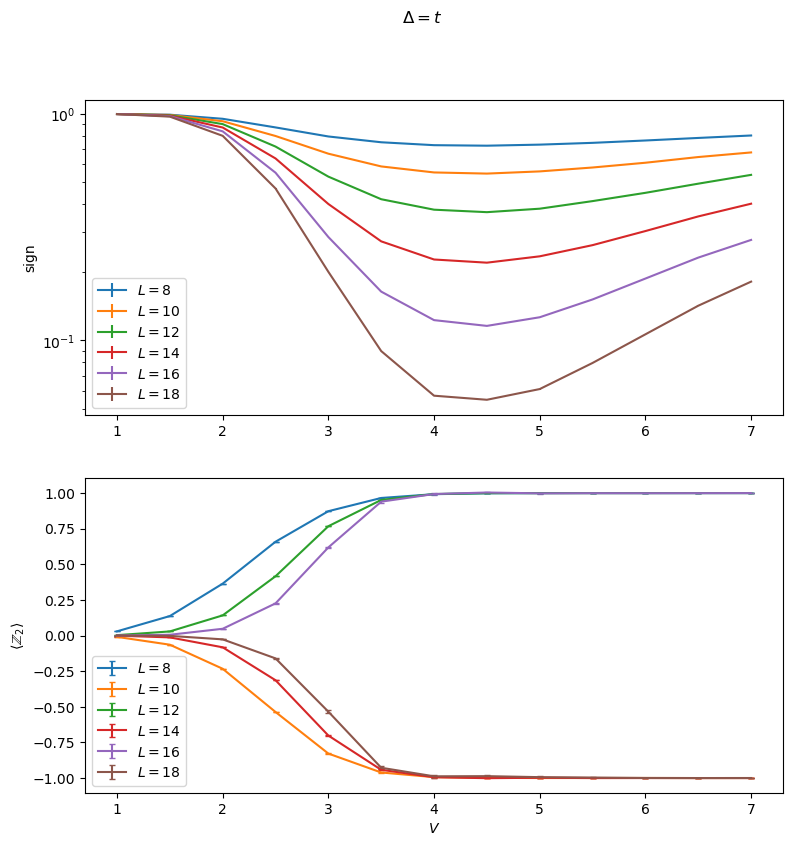

In [7]:
Vs = np.arange(1.0, 7.5, 0.5)
Ls = np.arange(8, 19, 2)

fig, axs = plt.subplots(2, 1, figsize=(9, 9))

for L in [8, 10, 12, 14, 16, 18]:
    signs = []
    signsStd = []
    z2PlusSigns = []
    z2PlusSignsStd = []
    z2MinusSigns = []
    z2MinusSignsStd = []
    for V in Vs:
        # print("L = {}, V = {}".format(L, V))
        # obs, params = getChainDataFromFile(L, V)
        # r = biningAndAnalysis(obs)
        r = data[(L, V)]
        signs.append(r["obsSign"][0])
        signsStd.append(r["obsSign"][1])
        z2PlusSigns.append(r["obsZ2"][0])
        z2PlusSignsStd.append(r["obsZ2"][1])

    axs[0].errorbar(Vs, signs, yerr=signsStd, label=r"$L = {}$".format(L))

    axs[1].errorbar(Vs, z2PlusSigns, yerr=z2PlusSignsStd, label=r"$L = {}$".format(L), capsize=2)

axs[0].set_ylabel(r"sign")
    # axs[0].set_ylim(0, 1.0)
axs[0].set_yscale("log")
axs[0].legend()
axs[1].set_ylabel(r"$\left<\mathbb{Z}_2 \right>$")
# axs[1].set_ylim(0, 1.0)
# axs[1].set_yscale("log")
axs[1].set_xlabel(r"$V$")
axs[1].legend()

fig.suptitle("$\Delta = t$")
plt.legend()
plt.show()


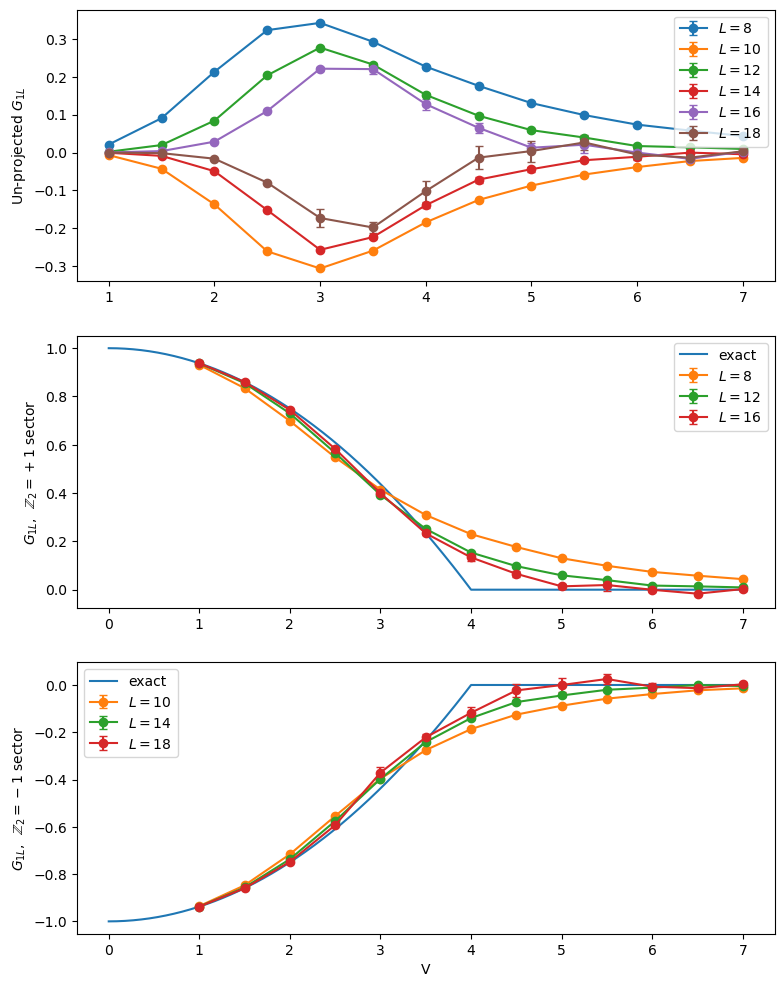

In [7]:
Vs = np.arange(1.0, 7.5, 0.5)

fig, axs = plt.subplots(3, 1, figsize=(9, 12))

cut = len(Vs)

xs = np.arange(0.0, 7.0, 0.01)
f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
ys = np.array([f(x) for x in xs])
axs[1].plot(xs, ys, label="exact")
axs[2].plot(xs, -ys, label="exact")

for L in [8, 10, 12, 14, 16, 18]:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    eCorr = []
    eCorrStd = []

    eCorrZ2Plus = []
    eCorrZ2PlusStd = []
    eCorrZ2Minus = []
    eCorrZ2MinusStd = []
    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        eCorr.append(r["obsEdgeCorrelator"][0])
        eCorrStd.append(r["obsEdgeCorrelator"][1])
        eCorrZ2Plus.append(r["obsEdgeCorrelatorPlus"][0])
        eCorrZ2PlusStd.append(r["obsEdgeCorrelatorPlus"][1])
        eCorrZ2Minus.append(r["obsEdgeCorrelatorMinus"][0])
        eCorrZ2MinusStd.append(r["obsEdgeCorrelatorMinus"][1])

    
        
    eCorrStd = np.clip(np.abs(eCorrStd), 0, 1)
    eCorrZ2PlusStd = np.clip(np.abs(eCorrZ2PlusStd), 0, 1)
    eCorrZ2MinusStd = np.clip(np.abs(eCorrZ2MinusStd), 0, 1)


    axs[0].errorbar(Vs, eCorr, yerr=eCorrStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    if L in [8, 12, 16]:
        axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), capsize=3, marker='o')
    
    if L in [10, 14, 18]:
        axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), capsize=3, marker='o')
    # axs[2].set_yscale("log")

axs[0].set_ylabel(r"Un-projected $G_{1L}$")
axs[0].legend()

axs[1].set_ylabel(r"$G_{1L}$,  $\mathbb{Z}_2=+1$ sector")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"$G_{1L}$,  $\mathbb{Z}_2=-1$ sector")
axs[2].set_xlabel(r"V")
# axs[2].set_ylim(-1, 1.0)
axs[2].legend()
plt.legend()
plt.show()


## RG ratio

In [8]:
with open('./data/data_L8-14_V1.0-6.5_len160k_RG.pkl', 'rb') as f:
    data = pickle.load(f)

r = {}
for i in data:
    r[i[0]] = i[1]
data = r

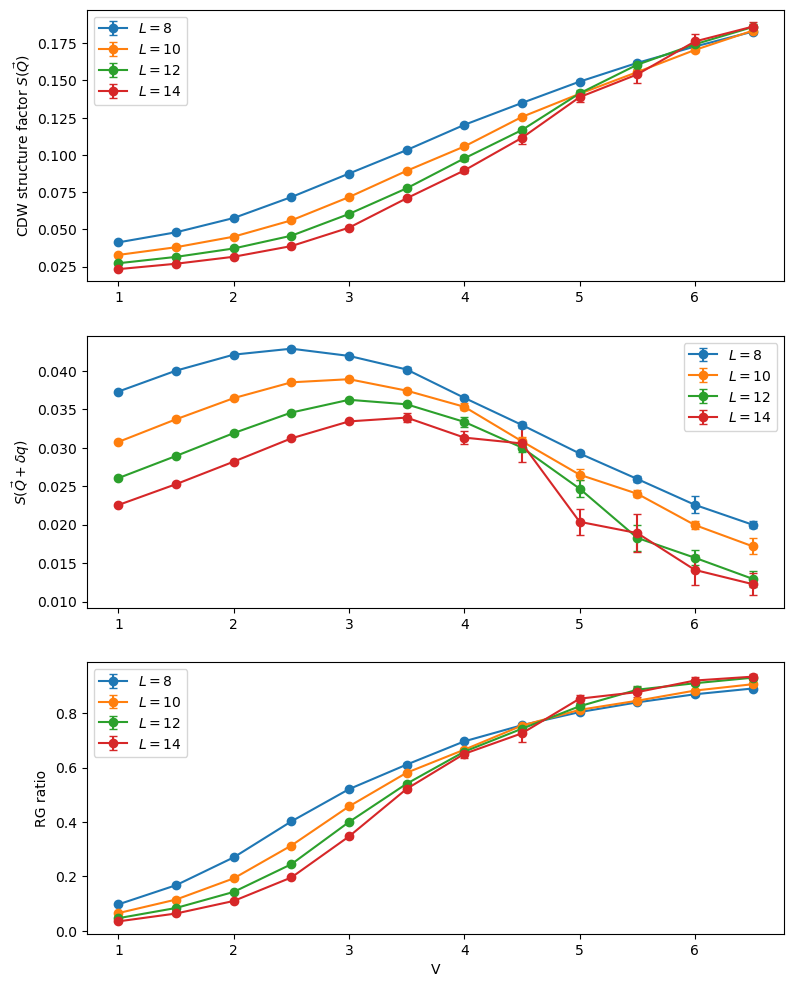

In [9]:
Vs = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5]

fig, axs = plt.subplots(3, 1, figsize=(9, 12))

cut = len(Vs)

# xs = np.arange(0.0, 7.0, 0.01)
# f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
# ys = np.array([f(x) for x in xs])
# axs[1].plot(xs, ys, label="exact")
# axs[2].plot(xs, -ys, label="exact")

for L in [8, 10, 12, 14]:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    cdw = []
    cdwStd = []

    cdwq = []
    cdwqStd = []

    rgRatio = []
    rgRatioStd = []

    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        cdw.append(r["obsCDW"][0])
        cdwStd.append(r["obsCDW"][1])
        cdwq.append(r["obsCDWq"][0])
        cdwqStd.append(r["obsCDWq"][1])
        rgRatio.append(r["rgRatio"][0])
        rgRatioStd.append(r["rgRatio"][1])


    axs[0].errorbar(Vs, -np.array(cdw), yerr=cdwStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[1].errorbar(Vs, -np.array(cdwq), yerr=cdwqStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[2].errorbar(Vs, 1.0 - np.array(rgRatio), yerr=rgRatioStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    # if L in [8, 12, 16]:
    #     axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    
    # if L in [10, 14, 18]:
    #     axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    # axs[2].set_yscale("log")

axs[0].set_ylabel(r"CDW structure factor $S(\vec{Q})$")
axs[0].legend()

axs[1].set_ylabel(r"$S(\vec{Q} + \delta q)$")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"RG ratio")
axs[2].set_xlabel(r"V")
# # axs[2].set_ylim(-1, 1.0)
# axs[2].legend()
plt.legend()
plt.show()


In [15]:
with open('./data/data_L8-14_V4.0-5.0-0.1_len320k.pkl', 'rb') as f:
    data = pickle.load(f)

r = {}
for i in data:
    r[i[0]] = i[1]
data = r

In [11]:
dataNew = [((12, 4.1), {'obsSign': (0.33765270551041665, 0.00030798388765791853), 'obsZ2': (0.9966459426406512, 0.000407737042653617), 'obsZ2Plus': (0.9983229713203254, 0.0002038685213266893), 'obsZ2Minus': (0.0016770286796744876, 0.00020386852132689204), 'obsEdgeCorrelator': (0.14092550287002492, 0.00133070643790739), 'obsEdgeCorrelatorPlus': (0.14172263274652733, 0.0012748247065742539), 'obsEdgeCorrelatorMinus': (-0.3336001156812363, 0.21157896927855302), 'obsCDW': (-0.10135342822098259, 0.0005556919894575216), 'obsCDWM4': (0.018720468796091176, 0.0001557382779220453), 'obsBinning': (1.8223837494114818, 0.008750227382053144), 'obsCDWq': (-0.03263138141832855, 0.00020605300678851356), 'rgRatio': (0.32195636605313643, 0.003531748402201365)}), ((12, 4.4), {'obsSign': (0.3331106249725001, 0.00030984884582804155), 'obsZ2': (0.9991037261437667, 0.0005772329966884299), 'obsZ2Plus': (0.9995518630718833, 0.000288616498344224), 'obsZ2Minus': (0.00044813692811648375, 0.00028861649834411153), 'obsEdgeCorrelator': (0.10779172812053657, 0.00227342925894464), 'obsEdgeCorrelatorPlus': (0.1077928418083162, 0.0022339427047380718), 'obsEdgeCorrelatorMinus': (0.10531200293192584, 1.005034917207811), 'obsCDW': (-0.11223341347968312, 0.0008999973135755064), 'obsCDWM4': (0.02152227141007191, 0.0002671668993567742), 'obsBinning': (1.7086132119701074, 0.009873495664615565), 'obsCDWq': (-0.03090524995892151, 0.0004216632873904037), 'rgRatio': (0.27536585599075836, 0.0040216821151931445)}), ((14, 4.1), {'obsSign': (0.19584374698041665, 0.00032063163174425265), 'obsZ2': (-0.9970608682072711, 0.0007831183468450265), 'obsZ2Plus': (0.001469565896364509, 0.0003915591734228497), 'obsZ2Minus': (0.9985304341036353, 0.0003915591734220297), 'obsEdgeCorrelator': (-0.11973188755943086, 0.002314746973769116), 'obsEdgeCorrelatorPlus': (0.4869744902074323, 0.394733547517896), 'obsEdgeCorrelatorMinus': (-0.12062479440540655, 0.0022300090527426954), 'obsCDW': (-0.09570705112491835, 0.003106096038001855), 'obsCDWM4': (0.016653457738617126, 0.0005631194713007299), 'obsBinning': (1.8180949213719368, 0.06139838720100011), 'obsCDWq': (-0.02914605121943008, 0.0018436152091501731), 'rgRatio': (0.3045340110905056, 0.02980240282073502)}), ((14, 4.4), {'obsSign': (0.1910812140494792, 0.0003202550034153386), 'obsZ2': (-1.000075203288568, 0.0007428664934922492), 'obsZ2Plus': (-3.760164428393109e-05, 0.0003714332467464395), 'obsZ2Minus': (1.0000376016442836, 0.0003714332467458309), 'obsEdgeCorrelator': (-0.08818511132948746, 0.0027987198924573514), 'obsEdgeCorrelatorPlus': (11.534357795011704, 169.37943432491173), 'obsEdgeCorrelatorMinus': (-0.08774843027287833, 0.0027548872091270674), 'obsCDW': (-0.11115659671901566, 0.002640879756777664), 'obsCDWM4': (0.02051891964850241, 0.0006389669595273936), 'obsBinning': (1.6606725568385978, 0.030027595804845684), 'obsCDWq': (-0.026584385137999485, 0.001758180144765049), 'rgRatio': (0.23916156576830938, 0.021656087931017545)})]


In [17]:
for i in dataNew:
    data[i[0]] = i[1]
    print(i[0])

(12, 4.1)
(12, 4.4)
(14, 4.1)
(14, 4.4)


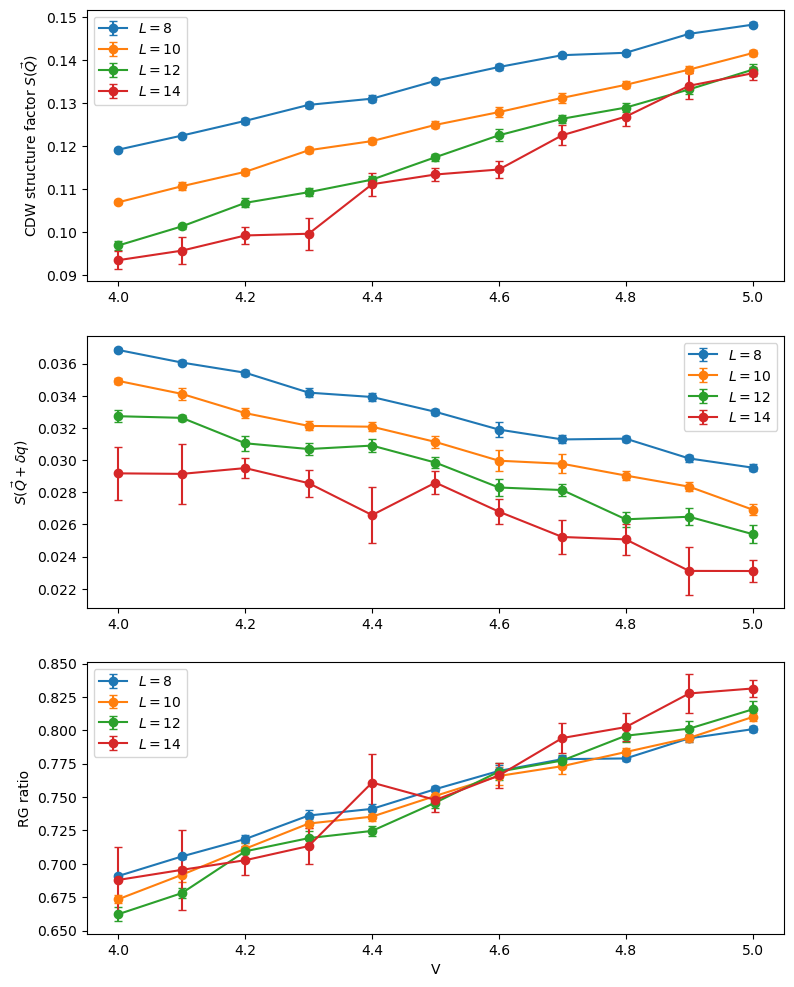

In [18]:
Vs = [4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0]

fig, axs = plt.subplots(3, 1, figsize=(9, 12))

cut = len(Vs)

# xs = np.arange(0.0, 7.0, 0.01)
# f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
# ys = np.array([f(x) for x in xs])
# axs[1].plot(xs, ys, label="exact")
# axs[2].plot(xs, -ys, label="exact")

for L in [8, 10, 12, 14]:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    cdw = []
    cdwStd = []

    cdwq = []
    cdwqStd = []

    rgRatio = []
    rgRatioStd = []

    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        cdw.append(r["obsCDW"][0])
        cdwStd.append(r["obsCDW"][1])
        cdwq.append(r["obsCDWq"][0])
        cdwqStd.append(r["obsCDWq"][1])
        rgRatio.append(r["rgRatio"][0])
        rgRatioStd.append(r["rgRatio"][1])


    axs[0].errorbar(Vs, -np.array(cdw), yerr=cdwStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[1].errorbar(Vs, -np.array(cdwq), yerr=cdwqStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[2].errorbar(Vs, 1.0 - np.array(rgRatio), yerr=rgRatioStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    # if L in [8, 12, 16]:
    #     axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    
    # if L in [10, 14, 18]:
    #     axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    # axs[2].set_yscale("log")

axs[0].set_ylabel(r"CDW structure factor $S(\vec{Q})$")
axs[0].legend()

axs[1].set_ylabel(r"$S(\vec{Q} + \delta q)$")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"RG ratio")
axs[2].set_xlabel(r"V")
# # axs[2].set_ylim(-1, 1.0)
# axs[2].legend()
plt.legend()
plt.show()


# $L_\tau = 5 L, \, \Delta = t$

In [9]:
with open('./data/data_L10-40_V2.0-6.0-0.1_len160k.pkl', 'rb') as f:
    data = pickle.load(f)

r = {}
for i in data:
    r[i[0]] = i[1]
data = r

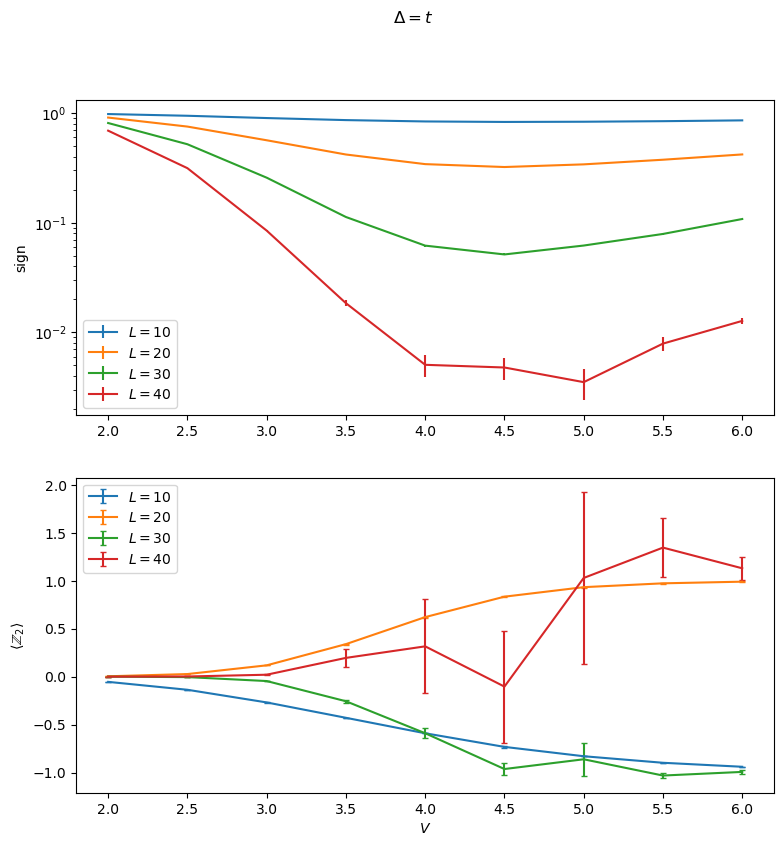

In [10]:
Vs = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

# Vs = np.arange(1.0, 7.5, 0.5)
# Ls = np.arange(8, 19, 2)

fig, axs = plt.subplots(2, 1, figsize=(9, 9))

for L in [10, 20, 30, 40]:
    signs = []
    signsStd = []
    z2PlusSigns = []
    z2PlusSignsStd = []
    z2MinusSigns = []
    z2MinusSignsStd = []
    for V in Vs:
        # print("L = {}, V = {}".format(L, V))
        # obs, params = getChainDataFromFile(L, V)
        # r = biningAndAnalysis(obs)
        r = data[(L, V)]
        signs.append(r["obsSign"][0])
        signsStd.append(r["obsSign"][1])
        z2PlusSigns.append(r["obsZ2"][0])
        z2PlusSignsStd.append(r["obsZ2"][1])

    axs[0].errorbar(Vs, signs, yerr=signsStd, label=r"$L = {}$".format(L))

    axs[1].errorbar(Vs, z2PlusSigns, yerr=z2PlusSignsStd, label=r"$L = {}$".format(L), capsize=2)

axs[0].set_ylabel(r"sign")
    # axs[0].set_ylim(0, 1.0)
axs[0].set_yscale("log")
axs[0].legend()
axs[1].set_ylabel(r"$\left<\mathbb{Z}_2 \right>$")
# axs[1].set_ylim(0, 1.0)
# axs[1].set_yscale("log")
axs[1].set_xlabel(r"$V$")
axs[1].legend()

fig.suptitle("$\Delta = t$")
plt.legend()
plt.show()



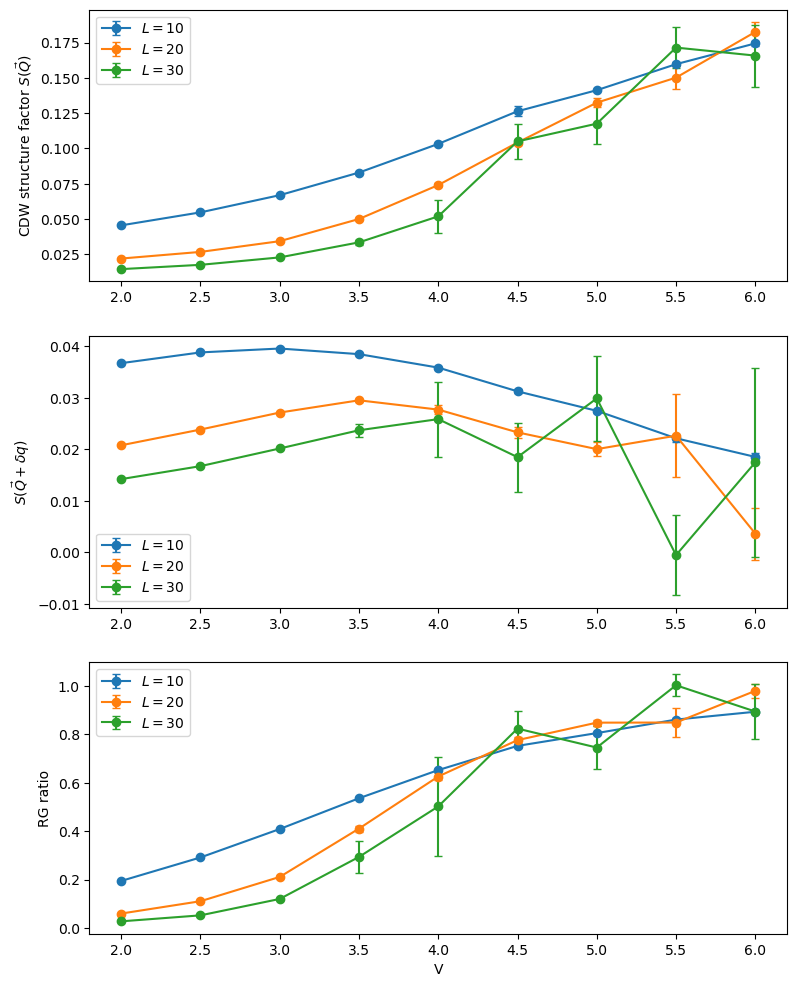

In [12]:
Vs = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

fig, axs = plt.subplots(3, 1, figsize=(9, 12))

cut = len(Vs)

# xs = np.arange(0.0, 7.0, 0.01)
# f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
# ys = np.array([f(x) for x in xs])
# axs[1].plot(xs, ys, label="exact")
# axs[2].plot(xs, -ys, label="exact")

for L in [10, 20, 30]:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    cdw = []
    cdwStd = []

    cdwq = []
    cdwqStd = []

    rgRatio = []
    rgRatioStd = []

    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        cdw.append(r["obsCDW"][0])
        cdwStd.append(r["obsCDW"][1])
        cdwq.append(r["obsCDWq"][0])
        cdwqStd.append(r["obsCDWq"][1])
        rgRatio.append(r["rgRatio"][0])
        rgRatioStd.append(r["rgRatio"][1])


    axs[0].errorbar(Vs, -np.array(cdw), yerr=cdwStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[1].errorbar(Vs, -np.array(cdwq), yerr=cdwqStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[2].errorbar(Vs, 1.0 - np.array(rgRatio), yerr=rgRatioStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    # if L in [8, 12, 16]:
    #     axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    
    # if L in [10, 14, 18]:
    #     axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    # axs[2].set_yscale("log")

axs[0].set_ylabel(r"CDW structure factor $S(\vec{Q})$")
axs[0].legend()

axs[1].set_ylabel(r"$S(\vec{Q} + \delta q)$")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"RG ratio")
axs[2].set_xlabel(r"V")
# # axs[2].set_ylim(-1, 1.0)
# axs[2].legend()
plt.legend()
plt.show()


## $L_\tau = 1.0 * L$

In [10]:
data = [((10, 2.0), {'obsSign': (0.9998175, 2.1263660001386937e-05), 'obsZ2': (-0.008609120413854492, 5.9115633570936104e-05), 'obsZ2Plus': (0.4956954397930729, 2.9557816785462397e-05), 'obsZ2Minus': (0.5043045602069272, 2.9557816785546755e-05), 'obsEdgeCorrelator': (-7.300258843387922e-05, 2.8467571943382863e-05), 'obsEdgeCorrelatorPlus': (0.06062532376675078, 0.00019929287888335805), 'obsEdgeCorrelatorMinus': (-0.0597351312927648, 0.0001971077944973414), 'obsCDW': (-0.04407973111469346, 1.9776057943088483e-05), 'obsCDWM4': (0.0049468781915601385, 3.7503364759095454e-06), 'obsBinning': (2.54597036045149, 0.0005315037644259695), 'obsCDWq': (-0.036495789696335365, 6.723355629296457e-06), 'rgRatio': (0.8279494628042664, 0.0002739882227798847)}), ((10, 2.5), {'obsSign': (0.9984100000000001, 6.361598363754371e-05), 'obsZ2': (-0.023171479887353186, 0.00013740762740192995), 'obsZ2Plus': (0.48841426005632343, 6.87038137009411e-05), 'obsZ2Minus': (0.5115857399436766, 6.870381370100101e-05), 'obsEdgeCorrelator': (-8.22111023819907e-05, 7.288920306614199e-05), 'obsEdgeCorrelatorPlus': (0.050448116004756925, 0.0002739872361850154), 'obsEdgeCorrelatorMinus': (-0.048323845685415166, 0.000263446652685889), 'obsCDW': (-0.05101727696545211, 0.00010922458295079083), 'obsCDWM4': (0.006396210215334438, 2.410952962244151e-05), 'obsBinning': (2.457469743446217, 0.0015351100225044997), 'obsCDWq': (-0.03868679665042381, 4.934364430256434e-05), 'rgRatio': (0.7583077534626509, 0.002482517792276102)}), ((10, 3.0), {'obsSign': (0.9947900000000001, 0.00011487444022552323), 'obsZ2': (-0.049577402344871076, 0.0003034124961145722), 'obsZ2Plus': (0.47521129882756447, 0.00015170624805717434), 'obsZ2Minus': (0.5247887011724356, 0.00015170624805739235), 'obsEdgeCorrelator': (-0.000143449293182233, 0.0001293747240469497), 'obsEdgeCorrelatorPlus': (0.04031976370898122, 0.000482587466963912), 'obsEdgeCorrelatorMinus': (-0.03678405523747758, 0.00043490439304292054), 'obsCDW': (-0.05929610443525824, 0.00020256750073125186), 'obsCDWM4': (0.00824816522911221, 4.7532179317079304e-05), 'obsBinning': (2.345875864044278, 0.0037425523976800865), 'obsCDWq': (-0.04021838349327629, 0.00010124931748103845), 'rgRatio': (0.6782635041171925, 0.003532909998231048)}), ((10, 3.5), {'obsSign': (0.9887350000000001, 0.00016674365746833307), 'obsZ2': (-0.09049271504111395, 0.00044787786714407763), 'obsZ2Plus': (0.45475364247944294, 0.00022393893357218554), 'obsZ2Minus': (0.5452463575205571, 0.0002239389335718146), 'obsEdgeCorrelator': (-0.000786000557798418, 0.00044355187172964955), 'obsEdgeCorrelatorPlus': (0.03112267589358273, 0.0008063604296675316), 'obsEdgeCorrelatorMinus': (-0.02739890065191307, 0.0008405030782843461), 'obsCDW': (-0.06885871096223078, 0.00028020449570257273), 'obsCDWM4': (0.010528645063054828, 6.647492154140265e-05), 'obsBinning': (2.2205200976657045, 0.004988218520841881), 'obsCDWq': (-0.04104929711683365, 9.12748685905014e-05), 'rgRatio': (0.5961380434212379, 0.0033083321285042318)}), ((10, 4.0), {'obsSign': (0.9824750000000002, 0.00021086691298855358), 'obsZ2': (-0.14709218615892938, 0.0006888082885214556), 'obsZ2Plus': (0.4264539069205352, 0.00034440414426056604), 'obsZ2Minus': (0.5735460930794648, 0.0003444041442608718), 'obsEdgeCorrelator': (-0.000585633564206457, 0.0006119468115462969), 'obsEdgeCorrelatorPlus': (0.026918296405472435, 0.0012823950304525565), 'obsEdgeCorrelatorMinus': (-0.021035879030945035, 0.0008174217488719142), 'obsCDW': (-0.07983168680051052, 0.0003381734990301913), 'obsCDWM4': (0.013283719362435034, 8.614188615906608e-05), 'obsBinning': (2.084342482983935, 0.0053582463336427355), 'obsCDWq': (-0.04107883078284167, 8.962710401465065e-05), 'rgRatio': (0.514567993157308, 0.00228422183586514)}), ((10, 4.5), {'obsSign': (0.9765750000000001, 0.0002415387432661779), 'obsZ2': (-0.2190245770638692, 0.003739215374151812), 'obsZ2Plus': (0.3904877114680653, 0.0018696076870759284), 'obsZ2Minus': (0.6095122885319345, 0.0018696076870759325), 'obsEdgeCorrelator': (-0.0019807766110274978, 0.0012680015723711864), 'obsEdgeCorrelatorPlus': (0.024125215326776955, 0.003982742234088007), 'obsEdgeCorrelatorMinus': (-0.01870573518618384, 0.0025025990032090397), 'obsCDW': (-0.09191683237549096, 0.0006398947015247551), 'obsCDWM4': (0.016363596985104215, 0.00015301277037972516), 'obsBinning': (1.9368173954760146, 0.009554177643537911), 'obsCDWq': (-0.03932127508897593, 0.000286923748085921), 'rgRatio': (0.42779189097374876, 0.005843991905211201)}), ((10, 5.0), {'obsSign': (0.9726225000000001, 0.00026212859562587044), 'obsZ2': (-0.2954542831272589, 0.0014545617609255253), 'obsZ2Plus': (0.35227285843637063, 0.0007272808804627297), 'obsZ2Minus': (0.6477271415636294, 0.0007272808804628273), 'obsEdgeCorrelator': (-0.0001290064519533966, 0.0005920153406983914), 'obsEdgeCorrelatorPlus': (0.01393434249837721, 0.0019637921811189204), 'obsEdgeCorrelatorMinus': (-0.007777499042292976, 0.0012559726687218476), 'obsCDW': (-0.10516742351331268, 0.0008107507163132101), 'obsCDWM4': (0.02034315231557347, 0.0005000616528512017), 'obsBinning': (1.8393135626127783, 0.023381057464743657), 'obsCDWq': (-0.03789184937851337, 0.00018333880584436887), 'rgRatio': (0.3603002568372796, 0.003620328636432787)}), ((10, 5.5), {'obsSign': (0.9696500000000001, 0.0002764629115851244), 'obsZ2': (-0.3753267167324028, 0.0014178489165975101), 'obsZ2Plus': (0.31233664163379854, 0.0007089244582985298), 'obsZ2Minus': (0.6876633583662015, 0.00070892445829893), 'obsEdgeCorrelator': (-0.0005255840663508907, 0.0007650284946419612), 'obsEdgeCorrelatorPlus': (0.012558035373981064, 0.0023727838248180353), 'obsEdgeCorrelatorMinus': (-0.00646816293737348, 0.0011943495079488966), 'obsCDW': (-0.11844660002032295, 0.0009303278442759094), 'obsCDWM4': (0.02372283041373991, 0.0002613685074938056), 'obsBinning': (1.6909131725305702, 0.009951281668666377), 'obsCDWq': (-0.034743281484937535, 0.00040258817946236896), 'rgRatio': (0.29332443534723884, 0.005434321970068687)}), ((10, 6.0), {'obsSign': (0.9686825000000001, 0.00027958504727544175), 'obsZ2': (-0.4594445881641345, 0.00152222637473526), 'obsZ2Plus': (0.2702777059179327, 0.0007611131873674249), 'obsZ2Minus': (0.7297222940820672, 0.0007611131873678683), 'obsEdgeCorrelator': (0.000915713396085043, 0.0018518252858915401), 'obsEdgeCorrelatorPlus': (0.018163464911279605, 0.004385903550320091), 'obsEdgeCorrelatorMinus': (-0.005472583506031541, 0.0015183889998805875), 'obsCDW': (-0.1304507156724569, 0.0006677416900933682), 'obsCDWM4': (0.027126033224114523, 0.0001977518116114118), 'obsBinning': (1.594018501523597, 0.00780069332536964), 'obsCDWq': (-0.0324577963118557, 0.0002758804424829597), 'rgRatio': (0.24881271335332683, 0.0030624844666568476)}), ((20, 2.0), {'obsSign': (0.9814725000000001, 0.00021492089671023407), 'obsZ2': (0.0008855300652054154, 3.1401891833609356e-05), 'obsZ2Plus': (0.5004427650326028, 1.570094591681905e-05), 'obsZ2Minus': (0.49955723496739723, 1.5700945916738935e-05), 'obsEdgeCorrelator': (3.700259336022675e-05, 1.5291070118187755e-05), 'obsEdgeCorrelatorPlus': (0.23766033963534855, 0.0008115276909742202), 'obsEdgeCorrelatorMinus': (-0.2380075526700253, 0.0008267714212604461), 'obsCDW': (-0.02316562312602711, 2.2182876345602865e-05), 'obsCDWM4': (0.001489203897954221, 2.78849752518643e-06), 'obsBinning': (2.775020469149604, 0.000827255375070053), 'obsCDWq': (-0.021558918088101696, 1.5507642926406702e-05), 'rgRatio': (0.930642701537568, 0.0003273700327771946)}), ((20, 2.5), {'obsSign': (0.9356325000000001, 0.0004057307545028754), 'obsZ2': (0.006335475748164845, 0.00012967429226306944), 'obsZ2Plus': (0.5031677378740824, 6.483714613138378e-05), 'obsZ2Minus': (0.4968322621259175, 6.483714613159608e-05), 'obsEdgeCorrelator': (8.39059100860707e-05, 0.0001006753596543867), 'obsEdgeCorrelatorPlus': (0.14652085897948688, 0.0007402075777033282), 'obsEdgeCorrelatorMinus': (-0.14822037308710465, 0.0007384231262031986), 'obsCDW': (-0.028207076903043145, 3.7409172018354226e-05), 'obsCDWM4': (0.002155278706851088, 5.15214222254636e-06), 'obsBinning': (2.7088644460811855, 0.0027626734003259774), 'obsCDWq': (-0.024771919167833275, 2.526534056870074e-05), 'rgRatio': (0.8782164580400112, 0.0005023133943015863)}), ((20, 3.0), {'obsSign': (0.8718400000000002, 0.0005554420394333966), 'obsZ2': (0.02688963946407499, 0.0004514064392513731), 'obsZ2Plus': (0.5134448197320374, 0.00022570321962573278), 'obsZ2Minus': (0.4865551802679625, 0.00022570321962568567), 'obsEdgeCorrelator': (0.00029141260781265135, 0.00025323542516230313), 'obsEdgeCorrelatorPlus': (0.07979608588579003, 0.0011270937490291274), 'obsEdgeCorrelatorMinus': (-0.0836071138019214, 0.0011917942904822296), 'obsCDW': (-0.03548348528815473, 7.50587110048278e-05), 'obsCDWM4': (0.0032691500255105027, 1.235158339795018e-05), 'obsBinning': (2.5964640242174157, 0.00417805234476988), 'obsCDWq': (-0.02815229856274019, 3.855689202155809e-05), 'rgRatio': (0.7933915832466063, 0.001277636039352427)}), ((20, 3.5), {'obsSign': (0.8084750000000002, 0.0006731110101705247), 'obsZ2': (0.07780408979770195, 0.0010077931526517366), 'obsZ2Plus': (0.538902044898851, 0.0005038965763258898), 'obsZ2Minus': (0.46109795510114904, 0.0005038965763258678), 'obsEdgeCorrelator': (-0.00032220836224508694, 0.0011006694729565458), 'obsEdgeCorrelatorPlus': (0.03457760028779515, 0.001931477527684113), 'obsEdgeCorrelatorMinus': (-0.04111089124491944, 0.0028574275329315488), 'obsCDW': (-0.0462849393272703, 0.00017900002517101242), 'obsCDWM4': (0.005185093246430902, 3.468324150719439e-05), 'obsBinning': (2.4203444311741795, 0.008931312980513298), 'obsCDWq': (-0.030985527599965767, 8.340337817102523e-05), 'rgRatio': (0.6694516208527702, 0.002997277087262647)}), ((20, 4.0), {'obsSign': (0.7603825, 0.0007456842553811153), 'obsZ2': (0.17528400479674497, 0.001561219020876915), 'obsZ2Plus': (0.5876420023983726, 0.0007806095104384979), 'obsZ2Minus': (0.4123579976016275, 0.0007806095104384289), 'obsEdgeCorrelator': (0.000814497396500183, 0.0009609399467415174), 'obsEdgeCorrelatorPlus': (0.015143177012371445, 0.0021231008221234762), 'obsEdgeCorrelatorMinus': (-0.019604978049910814, 0.0027160819034071984), 'obsCDW': (-0.06260936843792914, 0.0006184043086471306), 'obsCDWM4': (0.008882040882319526, 0.0005102196727188841), 'obsBinning': (2.2658653064867313, 0.10100659882511856), 'obsCDWq': (-0.032145193810756596, 0.00022898129237377348), 'rgRatio': (0.5134246673001601, 0.005786650207998094)}), ((20, 4.5), {'obsSign': (0.7360074999999999, 0.0007679518004395889), 'obsZ2': (0.3142750577737322, 0.004428984289879733), 'obsZ2Plus': (0.6571375288868663, 0.002214492144939778), 'obsZ2Minus': (0.3428624711131339, 0.002214492144939797), 'obsEdgeCorrelator': (0.0003516859900150598, 0.0012720278342030896), 'obsEdgeCorrelatorPlus': (0.005663193588648147, 0.0022694143584420417), 'obsEdgeCorrelatorMinus': (-0.009828463061171093, 0.004100621515465465), 'obsCDW': (-0.0805467420611921, 0.000669351216236554), 'obsCDWM4': (0.01248186923407725, 0.00016375414246513347), 'obsBinning': (1.9239052143537778, 0.016291582024088147), 'obsCDWq': (-0.03146008498124447, 0.0002831241805778091), 'rgRatio': (0.3905817246180205, 0.006037611994691213)}), ((20, 5.0), {'obsSign': (0.728, 0.0007686263004810468), 'obsZ2': (0.4633892151402747, 0.003317312180213016), 'obsZ2Plus': (0.7316946075701374, 0.0016586560901065194), 'obsZ2Minus': (0.2683053924298627, 0.0016586560901065651), 'obsEdgeCorrelator': (0.0002667629416664988, 0.002027849677515294), 'obsEdgeCorrelatorPlus': (-0.0013978783355181098, 0.00283648992343944), 'obsEdgeCorrelatorMinus': (0.004806399837491767, 0.006316435933063368), 'obsCDW': (-0.10226561271951752, 0.000583286600552138), 'obsCDWM4': (0.01772375204478633, 0.00018074455245216452), 'obsBinning': (1.6947139988145246, 0.013806475288672938), 'obsCDWq': (-0.02881820147193755, 0.0002890753462695681), 'rgRatio': (0.28179757519732307, 0.003878885669047045)}), ((20, 5.5), {'obsSign': (0.734272467775, 0.0007611080911543136), 'obsZ2': (0.6021477999943723, 0.004101017594353933), 'obsZ2Plus': (0.8010738999971861, 0.0020505087971769693), 'obsZ2Minus': (0.19892610000281397, 0.0020505087971769455), 'obsEdgeCorrelator': (-0.0033436942743155225, 0.0018885271126768658), 'obsEdgeCorrelatorPlus': (-0.0026702689785344964, 0.00300495867668), 'obsEdgeCorrelatorMinus': (-0.0060555737560197016, 0.011743604110548657), 'obsCDW': (-0.1270819520648911, 0.0010807665530778315), 'obsCDWM4': (0.0237853493587232, 0.0002990455480318091), 'obsBinning': (1.4727932443027751, 0.01691577548423984), 'obsCDWq': (-0.024062618946458152, 0.0005229834270118414), 'rgRatio': (0.1893472613198701, 0.005455076392482241)}), ((20, 6.0), {'obsSign': (0.7505850000000001, 0.0007561936972937416), 'obsZ2': (0.7272370651187159, 0.00486396370955786), 'obsZ2Plus': (0.863618532559358, 0.002431981854778918), 'obsZ2Minus': (0.13638146744064192, 0.002431981854778878), 'obsEdgeCorrelator': (-0.0014208092689760726, 0.0028564229529435747), 'obsEdgeCorrelatorPlus': (-0.003992956741679933, 0.0036488410093330646), 'obsEdgeCorrelatorMinus': (0.014866994402414456, 0.019890132989716067), 'obsCDW': (-0.14934233043335515, 0.0013421936088480278), 'obsCDWM4': (0.03012279434926797, 0.0006284858613078883), 'obsBinning': (1.3506082842094387, 0.02313286331614645), 'obsCDWq': (-0.018975032478454397, 0.0007150681823138387), 'rgRatio': (0.1270572997427559, 0.005667084453453884)}), ((30, 2.0), {'obsSign': (0.9449725000000001, 0.00036858854113758357), 'obsZ2': (-8.356783365180912e-05, 1.046045359803951e-05), 'obsZ2Plus': (0.49995821608317403, 5.230226799033595e-06), 'obsZ2Minus': (0.500041783916826, 5.230226798940466e-06), 'obsEdgeCorrelator': (3.285020122868284e-06, 4.882379301114798e-06), 'obsEdgeCorrelatorPlus': (0.4622400160514806, 0.0008329699513837282), 'obsEdgeCorrelatorMinus': (-0.462156196222336, 0.0008326793796648908), 'obsCDW': (-0.01493888966884614, 7.725861249794807e-06), 'obsCDWM4': (0.0006379541683695717, 6.28763659448812e-07), 'obsBinning': (2.858596382896066, 0.0005397091757790773), 'obsCDWq': (-0.014475417127560791, 6.532799773765076e-06), 'rgRatio': (0.9689754358262951, 0.00011443688826176823)}), ((30, 2.5), {'obsSign': (0.8195525, 0.0006469706634391349), 'obsZ2': (-0.001177485890397163, 9.510931980242474e-05), 'obsZ2Plus': (0.49941125705480144, 4.755465990124277e-05), 'obsZ2Minus': (0.5005887429451986, 4.755465990117863e-05), 'obsEdgeCorrelator': (-3.2224622529554173e-05, 5.295464913343801e-05), 'obsEdgeCorrelatorPlus': (0.2828669202995264, 0.0018109328755505703), 'obsEdgeCorrelatorMinus': (-0.28226593358557867, 0.001803127447021817), 'obsCDW': (-0.01836777573669489, 2.5367233555702013e-05), 'obsCDWM4': (0.0009492879569750568, 2.4431810260708663e-06), 'obsBinning': (2.8137456386757718, 0.0019242120873166093), 'obsCDWq': (-0.017221568082671602, 1.9167517820973307e-05), 'rgRatio': (0.9375968179828512, 0.0007858505953732139)}), ((30, 3.0), {'obsSign': (0.6535675, 0.0008574896670210826), 'obsZ2': (-0.012241341040261842, 0.0005274033719342126), 'obsZ2Plus': (0.493879329479869, 0.00026370168596715247), 'obsZ2Minus': (0.5061206705201311, 0.00026370168596713783), 'obsEdgeCorrelator': (-0.00014827291323398108, 0.000302786902927912), 'obsEdgeCorrelatorPlus': (0.13414410176056926, 0.0022927430781957883), 'obsEdgeCorrelatorMinus': (-0.1311925708774894, 0.002229189162462368), 'obsCDW': (-0.02415156256391756, 0.000103385444592311), 'obsCDWM4': (0.0015860406928321958, 1.2288531104454503e-05), 'obsBinning': (2.719091718655442, 0.008008193636628877), 'obsCDWq': (-0.020979700872471845, 7.282664351236764e-05), 'rgRatio': (0.868668469545345, 0.0022541272030062736)}), ((30, 3.5), {'obsSign': (0.5127825, 0.0009821928526626568), 'obsZ2': (-0.060784764653141594, 0.00248286629162754), 'obsZ2Plus': (0.46960761767342923, 0.001241433145813789), 'obsZ2Minus': (0.5303923823265707, 0.0012414331458137648), 'obsEdgeCorrelator': (-0.0013696604165993156, 0.001334002173912543), 'obsEdgeCorrelatorPlus': (0.04844417781834039, 0.003317766412530929), 'obsEdgeCorrelatorMinus': (-0.04547466392135327, 0.0029147471774439377), 'obsCDW': (-0.03398235213015793, 0.00020095094480434674), 'obsCDWM4': (0.0029216725762144743, 3.641895160125828e-05), 'obsBinning': (2.5300241829714376, 0.02242744734825277), 'obsCDWq': (-0.02487492194158671, 0.00012589473113710925), 'rgRatio': (0.7319952990791969, 0.004346149916192049)}), ((30, 4.0), {'obsSign': (0.423275, 0.0010081041179898214), 'obsZ2': (-0.1867658698062817, 0.004016499812837081), 'obsZ2Plus': (0.4066170650968592, 0.0020082499064186317), 'obsZ2Minus': (0.593382934903141, 0.0020082499064185506), 'obsEdgeCorrelator': (-0.003220192312284795, 0.0024206967109734485), 'obsEdgeCorrelatorPlus': (0.03769689147855692, 0.025360642502494552), 'obsEdgeCorrelatorMinus': (-0.03125871841411254, 0.01728508396788269), 'obsCDW': (-0.05200791706822338, 0.000750758753249121), 'obsCDWM4': (0.00577202641990785, 0.00016539497916732854), 'obsBinning': (2.133975307366228, 0.044012507815063794), 'obsCDWq': (-0.028152758673284473, 0.0004438975114402976), 'rgRatio': (0.541316799494241, 0.010110743414562529)}), ((30, 4.5), {'obsSign': (0.3889500000000001, 0.0010438742570096089), 'obsZ2': (-0.39522978522624236, 0.009538454430713076), 'obsZ2Plus': (0.30238510738687874, 0.004769227215356512), 'obsZ2Minus': (0.697614892613121, 0.004769227215356621), 'obsEdgeCorrelator': (-0.010119051692767911, 0.005574134226273964), 'obsEdgeCorrelatorPlus': (-0.030721390014737535, 0.01686199065663823), 'obsEdgeCorrelatorMinus': (-0.0011888544758289078, 0.005942850927067059), 'obsCDW': (-0.07850975506866756, 0.0011469038306711346), 'obsCDWM4': (0.010959606248485151, 0.00023619063756923788), 'obsBinning': (1.7780653269802593, 0.03012587771184156), 'obsCDWq': (-0.02629481538353502, 0.0007306604914094673), 'rgRatio': (0.3349242000076132, 0.012960300198484792)}), ((30, 5.0), {'obsSign': (0.39145241763000005, 0.0010411790097201122), 'obsZ2': (-0.6059735117153016, 0.008643108945396586), 'obsZ2Plus': (0.19701324414234916, 0.0043215544726982365), 'obsZ2Minus': (0.8029867558576507, 0.004321554472698278), 'obsEdgeCorrelator': (0.0006235209649106562, 0.004332661615708258), 'obsEdgeCorrelatorPlus': (0.004317096762247932, 0.023278240238373334), 'obsEdgeCorrelatorMinus': (-0.0002826968159999901, 0.005446144355182998), 'obsCDW': (-0.1096442303471932, 0.0016340544586063391), 'obsCDWM4': (0.017682488600301482, 0.0006001021281111559), 'obsBinning': (1.470861648881573, 0.043245016300555925), 'obsCDWq': (-0.022220825749448978, 0.0007537781832058543), 'rgRatio': (0.20266298661180712, 0.009004409647274654)}), ((30, 5.5), {'obsSign': (0.41395446654500007, 0.0010162315536208248), 'obsZ2': (-0.7764164247100166, 0.017189402665630106), 'obsZ2Plus': (0.11179178764499162, 0.008594701332815), 'obsZ2Minus': (0.8882082123550084, 0.008594701332814987), 'obsEdgeCorrelator': (-0.0009512347204836234, 0.00528156475979489), 'obsEdgeCorrelatorPlus': (0.010723577111372184, 0.038066022592891366), 'obsEdgeCorrelatorMinus': (-0.002420657175720938, 0.0054264014775164135), 'obsCDW': (-0.13893190698352104, 0.0016777949274529573), 'obsCDWM4': (0.025615859450929826, 0.0005892291808715257), 'obsBinning': (1.3271039533821962, 0.03034707472954028), 'obsCDWq': (-0.016963906215116637, 0.0009405568008166718), 'rgRatio': (0.12210231456523801, 0.007825897949765055)}), ((30, 6.0), {'obsSign': (0.45185730163625, 0.0009876289656166753), 'obsZ2': (-0.8462249226462607, 0.0073969620056335405), 'obsZ2Plus': (0.07688753867686976, 0.0036984810028168353), 'obsZ2Minus': (0.9231124613231305, 0.003698481002816558), 'obsEdgeCorrelator': (-0.003342500740727433, 0.004323509597166357), 'obsEdgeCorrelatorPlus': (0.015026664056917773, 0.04581075792822056), 'obsEdgeCorrelatorMinus': (-0.004872497835216307, 0.0040462820066017495), 'obsCDW': (-0.16281180008343116, 0.003578761443479477), 'obsCDWM4': (0.03204441475935954, 0.0011540121908449389), 'obsBinning': (1.2088727490505005, 0.021784653861392653), 'obsCDWq': (-0.011055529562556158, 0.0014712661971541439), 'rgRatio': (0.06790376224095582, 0.010473380845298912)}), ((40, 2.0), {'obsSign': (0.9015374999999999, 0.0004815103770943032), 'obsZ2': (4.721803026077491e-06, 2.060261534447017e-06), 'obsZ2Plus': (0.5000023609015131, 1.0301307672855632e-06), 'obsZ2Minus': (0.4999976390984871, 1.030130767220354e-06), 'obsEdgeCorrelator': (-9.16099192913289e-07, 1.331227398590183e-06), 'obsEdgeCorrelatorPlus': (0.6133128585227021, 0.0008829112872835115), 'obsEdgeCorrelatorMinus': (-0.6133204826420866, 0.0008827208668778589), 'obsCDW': (-0.010996608693885572, 5.50260656598617e-06), 'obsCDWM4': (0.0003502634860205203, 3.3368230800883976e-07), 'obsBinning': (2.8965252792138, 0.00043267622372376326), 'obsCDWq': (-0.01081458890517017, 4.614299435652527e-06), 'rgRatio': (0.9834476433848961, 0.0001269338421584276)}), ((40, 2.5), {'obsSign': (0.6873, 0.0008154120811673455), 'obsZ2': (0.00014446892927720233, 4.6889205777700846e-05), 'obsZ2Plus': (0.5000722344646387, 2.344460288880461e-05), 'obsZ2Minus': (0.49992776553536133, 2.344460288888891e-05), 'obsEdgeCorrelator': (2.3654580552216338e-05, 3.19430559279943e-05), 'obsEdgeCorrelatorPlus': (0.4060847296935689, 0.0016559096830773732), 'obsEdgeCorrelatorMinus': (-0.4061547639030982, 0.0016551525775119122), 'obsCDW': (-0.013441400051982313, 1.8473534214248783e-05), 'obsCDWM4': (0.0005197106049281477, 1.5818634193670368e-06), 'obsBinning': (2.876554221666453, 0.0036137418086615363), 'obsCDWq': (-0.012970715862750221, 1.570796814854247e-05), 'rgRatio': (0.9649825027905312, 0.0002993704192077347)}), ((40, 3.0), {'obsSign': (0.43492250000000005, 0.0010187987381318887), 'obsZ2': (0.0026524446975324375, 0.0010097060359940523), 'obsZ2Plus': (0.5013262223487662, 0.0005048530179970763), 'obsZ2Minus': (0.4986737776512338, 0.0005048530179969968), 'obsEdgeCorrelator': (-0.0006240307126827927, 0.000683602048265583), 'obsEdgeCorrelatorPlus': (0.1995771127122557, 0.003607324311782235), 'obsEdgeCorrelatorMinus': (-0.20189004357195453, 0.0035397999606668505), 'obsCDW': (-0.017656245962360095, 0.00030749127703095586), 'obsCDWM4': (0.0008718379076928199, 3.055784257180811e-05), 'obsBinning': (2.7966556291501328, 0.01682536494064528), 'obsCDWq': (-0.016496756725746103, 0.00020632078709767243), 'rgRatio': (0.9343298163477862, 0.011984393383745634)}), ((40, 3.5), {'obsSign': (0.255535, 0.001090639343898716), 'obsZ2': (0.03454235856690226, 0.012255125351296546), 'obsZ2Plus': (0.5172711792834511, 0.006127562675648308), 'obsZ2Minus': (0.4827288207165488, 0.006127562675648222), 'obsEdgeCorrelator': (0.0023646288884841757, 0.0026237008148681682), 'obsEdgeCorrelatorPlus': (0.05743848892122249, 0.007398614342531233), 'obsEdgeCorrelatorMinus': (-0.056650117664550824, 0.007911202191872453), 'obsCDW': (-0.026687377252367125, 0.000824888596487412), 'obsCDWM4': (0.0018184796734027023, 0.00012128393933584007), 'obsBinning': (2.553269234986821, 0.06505299081865581), 'obsCDWq': (-0.021320566502074395, 0.0006504002630916817), 'rgRatio': (0.7989009212483871, 0.04194610761583026)}), ((40, 4.0), {'obsSign': (0.17065250000000004, 0.0011193986892463488), 'obsZ2': (0.17648443480200918, 0.013957654205483809), 'obsZ2Plus': (0.5882422174010045, 0.006978827102741969), 'obsZ2Minus': (0.41175778259899526, 0.006978827102741899), 'obsEdgeCorrelator': (-0.003937696778827326, 0.00973455332807141), 'obsEdgeCorrelatorPlus': (-0.019936403397363092, 0.015529514809126172), 'obsEdgeCorrelatorMinus': (0.01891825254234789, 0.021678633726970067), 'obsCDW': (-0.04354823307762866, 0.0014030959515546754), 'obsCDWM4': (0.004425040811334689, 0.00023976703746798154), 'obsBinning': (2.333330381368713, 0.10602863391746896), 'obsCDWq': (-0.02350381761602511, 0.0007336013330924236), 'rgRatio': (0.5397192795961226, 0.02557211471432403)}), ((40, 4.5), {'obsSign': (0.14410749327500003, 0.0011161219326198742), 'obsZ2': (0.43504711292347303, 0.03486280076409074), 'obsZ2Plus': (0.7175235564617365, 0.017431400382045437), 'obsZ2Minus': (0.2824764435382635, 0.017431400382045378), 'obsEdgeCorrelator': (-0.021564303023062222, 0.015198735121707847), 'obsEdgeCorrelatorPlus': (-0.06996370307384342, 0.04084385096886998), 'obsEdgeCorrelatorMinus': (0.10137551671552265, 0.10350242212669561), 'obsCDW': (-0.08198444739999007, 0.005831725953629589), 'obsCDWM4': (0.01016406803462744, 0.0010688265793876838), 'obsBinning': (1.512184926800016, 0.16342259434470233), 'obsCDWq': (-0.021986317593790473, 0.0034451416463429857), 'rgRatio': (0.2681771766515642, 0.06075370835584269)}), ((40, 5.0), {'obsSign': (0.14974969752750003, 0.001104719959066498), 'obsZ2': (0.7156306040532766, 0.029257074631128917), 'obsZ2Plus': (0.8578153020266381, 0.014628537315564497), 'obsZ2Minus': (0.14218469797336167, 0.014628537315564513), 'obsEdgeCorrelator': (0.014012794747841655, 0.01784134284314786), 'obsEdgeCorrelatorPlus': (-0.032801158141141616, 0.016380379690986678), 'obsEdgeCorrelatorMinus': (0.296446717353432, 0.10415044145185844), 'obsCDW': (-0.11241405977551583, 0.0047930873152523595), 'obsCDWM4': (0.018220299169529334, 0.0008604346185924256), 'obsBinning': (1.4418310149987201, 0.08161147799624863), 'obsCDWq': (-0.016202185511162554, 0.002686844392134555), 'rgRatio': (0.14412964853223542, 0.028455749295664357)}), ((40, 5.5), {'obsSign': (0.17422472642250003, 0.0010884581143120306), 'obsZ2': (0.8539682506268789, 0.023240714464617656), 'obsZ2Plus': (0.9269841253134394, 0.01162035723230878), 'obsZ2Minus': (0.07301587468656046, 0.011620357232308755), 'obsEdgeCorrelator': (-0.003658032504734651, 0.025235471830996187), 'obsEdgeCorrelatorPlus': (0.0013849056805267587, 0.01646873254387502), 'obsEdgeCorrelatorMinus': (-0.06768106747522482, 0.23697235254295557), 'obsCDW': (-0.15727200129751623, 0.011347547038048699), 'obsCDWM4': (0.024091730131436166, 0.003771514407202714), 'obsBinning': (0.9740139210872222, 0.1094380255149139), 'obsCDWq': (-0.013266563360732704, 0.00565462864823274), 'rgRatio': (0.08435455495933898, 0.039953125472800305)}), ((40, 6.0), {'obsSign': (0.21216957746625004, 0.0010947006332036923), 'obsZ2': (0.9532178135709293, 0.02847551562124801), 'obsZ2Plus': (0.9766089067854647, 0.014237757810624039), 'obsZ2Minus': (0.023391093214535332, 0.01423775781062397), 'obsEdgeCorrelator': (0.0065751536393607694, 0.010292095621183656), 'obsEdgeCorrelatorPlus': (0.0032323330343575697, 0.008853346528158902), 'obsEdgeCorrelatorMinus': (0.14614751258752598, 0.3642613157492471), 'obsCDW': (-0.17131484590535498, 0.0042746196829693715), 'obsCDWM4': (0.03328210844805068, 0.0010693807927282888), 'obsBinning': (1.1340204136955025, 0.04109200080301163), 'obsCDWq': (-0.008685026263312561, 0.001989569649169347), 'rgRatio': (0.050696306904501956, 0.01229053085261323)}), ((50, 2.0), {'obsSign': (0.8505325, 0.0005936506616827972), 'obsZ2': (-5.859810833408749e-07, 4.5916382033745203e-07), 'obsZ2Plus': (0.49999970700945834, 2.295819101431162e-07), 'obsZ2Minus': (0.5000002929905418, 2.2958191020055463e-07), 'obsEdgeCorrelator': (-1.0274429259498376e-07, 2.545987500984384e-07), 'obsEdgeCorrelatorPlus': (0.6917595051591782, 0.0009743143375436963), 'obsEdgeCorrelatorMinus': (-0.6917588999321509, 0.0009743384876896356), 'obsCDW': (-0.008741684940085499, 4.825393082372995e-06), 'obsCDWM4': (0.0002229505286579052, 2.4962910589561026e-07), 'obsBinning': (2.9175493209345085, 0.0005554231241495023), 'obsCDWq': (-0.008649762639831209, 4.579061186595777e-06), 'rgRatio': (0.9894846015533268, 3.778045631437687e-05)}), ((50, 2.5), {'obsSign': (0.5546975, 0.0009398481797853961), 'obsZ2': (7.0186340705271325e-06, 2.8221525555121012e-05), 'obsZ2Plus': (0.5000035093170354, 1.4110762777550142e-05), 'obsZ2Minus': (0.49999649068296476, 1.4110762777549921e-05), 'obsEdgeCorrelator': (-7.489649631312857e-06, 1.6232619754412984e-05), 'obsEdgeCorrelatorPlus': (0.4946125819189309, 0.0019226061186526082), 'obsEdgeCorrelatorMinus': (-0.4946345043812663, 0.0019219276155860803), 'obsCDW': (-0.010585120453240277, 1.756666488378672e-05), 'obsCDWM4': (0.0003244011696088817, 1.0879882154897902e-06), 'obsBinning': (2.895281547211489, 0.004737946339748786), 'obsCDWq': (-0.010361268592161691, 1.5148163137376439e-05), 'rgRatio': (0.9788522141497368, 0.00044652376153848385)}), ((50, 3.0), {'obsSign': (0.26092750000000003, 0.0011017544970040403), 'obsZ2': (-0.0017975404966468385, 0.0007670229346607379), 'obsZ2Plus': (0.4991012297516766, 0.00038351146733046193), 'obsZ2Minus': (0.5008987702483233, 0.0003835114673303133), 'obsEdgeCorrelator': (-0.0003606850782032454, 0.0006002034372624476), 'obsEdgeCorrelatorPlus': (0.25249341751497845, 0.006457743669383887), 'obsEdgeCorrelatorMinus': (-0.25230738773637695, 0.00648842422652548), 'obsCDW': (-0.013871901752660351, 9.393840412247532e-05), 'obsCDWM4': (0.0005528809926511826, 7.724090073100958e-06), 'obsBinning': (2.8731589292234463, 0.020362118272465694), 'obsCDWq': (-0.01305118629926831, 7.073397323257241e-05), 'rgRatio': (0.940836127757495, 0.004281839627332259)}), ((50, 3.5), {'obsSign': (0.102055, 0.0011225605311767997), 'obsZ2': (-0.043317730132769613, 0.011436988073915714), 'obsZ2Plus': (0.4783411349336152, 0.005718494036957824), 'obsZ2Minus': (0.5216588650663848, 0.005718494036957831), 'obsEdgeCorrelator': (0.01028073589354293, 0.010036766611872215), 'obsEdgeCorrelatorPlus': (0.073569128885196, 0.023933325392736987), 'obsEdgeCorrelatorMinus': (-0.04775228734466974, 0.019247600636836136), 'obsCDW': (-0.02113838684982465, 0.0007396491981306948), 'obsCDWM4': (0.001282020905387998, 0.00010789766770846217), 'obsBinning': (2.8691378699076195, 0.191276327249598), 'obsCDWq': (-0.018074188951671805, 0.0005189634976168169), 'rgRatio': (0.8550411452105862, 0.026678002710570286)}), ((50, 4.0), {'obsSign': (0.050039998042500006, 0.0010982033714010755), 'obsZ2': (-0.24987577911317757, 0.048489140064491246), 'obsZ2Plus': (0.3750621104434112, 0.024244570032245612), 'obsZ2Minus': (0.6249378895565888, 0.02424457003224545), 'obsEdgeCorrelator': (0.025464648823891236, 0.0305439681689226), 'obsEdgeCorrelatorPlus': (0.08254486600023682, 0.08344710501103612), 'obsEdgeCorrelatorMinus': (-0.008792563227812383, 0.04531751390241784), 'obsCDW': (-0.04057413633231593, 0.0043295217165351995), 'obsCDWM4': (0.0036544876280461703, 0.0008063253495644258), 'obsBinning': (2.2198772447155877, 0.5729908160473224), 'obsCDWq': (-0.024619976260950856, 0.0026491721476222777), 'rgRatio': (0.6067908708794464, 0.09757104798942212)}), ((50, 4.5), {'obsSign': (0.03549497919625, 0.0011263034403141748), 'obsZ2': (-0.5438871138419118, 0.1605887417135081), 'obsZ2Plus': (0.22805644307904413, 0.08029437085675407), 'obsZ2Minus': (0.7719435569209561, 0.08029437085675403), 'obsEdgeCorrelator': (-0.006303428716983773, 0.0627613765373636), 'obsEdgeCorrelatorPlus': (-0.006688727241151518, 0.2580452195985078), 'obsEdgeCorrelatorMinus': (-0.00619007353900239, 0.07483207617283637), 'obsCDW': (-0.07576260429513455, 0.015389349710031712), 'obsCDWM4': (0.008539652093315999, 0.00241860531958031), 'obsBinning': (1.4877570779421787, 0.35684517211973393), 'obsCDWq': (-0.023880503283219456, 0.008226335513071949), 'rgRatio': (0.315205007812884, 0.15572499546885551)}), ((50, 5.0), {'obsSign': (0.04168746276, 0.001110249882409178), 'obsZ2': (-0.8022620249933213, 0.11295423400683856), 'obsZ2Plus': (0.09886898750333933, 0.056477117003419286), 'obsZ2Minus': (0.9011310124966608, 0.05647711700341926), 'obsEdgeCorrelator': (0.08694822160094165, 0.067802889102508), 'obsEdgeCorrelatorPlus': (0.9807902937136644, 0.7902428642629692), 'obsEdgeCorrelatorMinus': (-0.011117310346440847, 0.06351706790383113), 'obsCDW': (-0.00854250060577827, 0.14276833763606103), 'obsCDWM4': (0.0044573117195674744, 0.01858344861623359), 'obsBinning': (61.506987512627965, 2435.042953422585), 'obsCDWq': (-0.10614624445212635, 0.08388256898143322), 'rgRatio': (12.433173290642786, 98.40415459777658)}), ((50, 5.5), {'obsSign': (0.054319902952500006, 0.0011151845609252622), 'obsZ2': (-0.7377885050101674, 0.09667032700501323), 'obsZ2Plus': (0.13110574749491624, 0.04833516350250661), 'obsZ2Minus': (0.8688942525050837, 0.048335163502506745), 'obsEdgeCorrelator': (0.060766882174814, 0.07469855728549628), 'obsEdgeCorrelatorPlus': (0.6520395707337455, 0.47579641143263124), 'obsEdgeCorrelatorMinus': (-0.02844736386506031, 0.06067731994655729), 'obsCDW': (-0.20165571132955884, 0.031410129967759645), 'obsCDWM4': (0.03167088119458232, 0.006397529750377452), 'obsBinning': (0.7788254816181026, 0.1388873275941877), 'obsCDWq': (-0.027022203077789936, 0.01944841912008713), 'rgRatio': (0.13400100976752669, 0.09477513247836995)}), ((50, 6.0), {'obsSign': (0.07711233753125, 0.001123471237946208), 'obsZ2': (-0.9101050792601714, 0.07774823524934808), 'obsZ2Plus': (0.044947460369914365, 0.03887411762467406), 'obsZ2Minus': (0.9550525396300859, 0.038874117624674076), 'obsEdgeCorrelator': (-0.00991210651100326, 0.03593507175220959), 'obsEdgeCorrelatorPlus': (-0.37900604763431256, 0.8684540358429587), 'obsEdgeCorrelatorMinus': (0.007456386951736956, 0.03224847424730807), 'obsCDW': (-0.1704845786049833, 0.03198597365242281), 'obsCDWM4': (0.02893161226486711, 0.011515844471312342), 'obsBinning': (0.9954086365878034, 0.13506609433189254), 'obsCDWq': (0.020346515352284347, 0.015826869649237595), 'rgRatio': (-0.11934657947265939, 0.09491138991617627)})]

In [11]:
r = {}
for i in data:
    r[i[0]] = i[1]
data = r

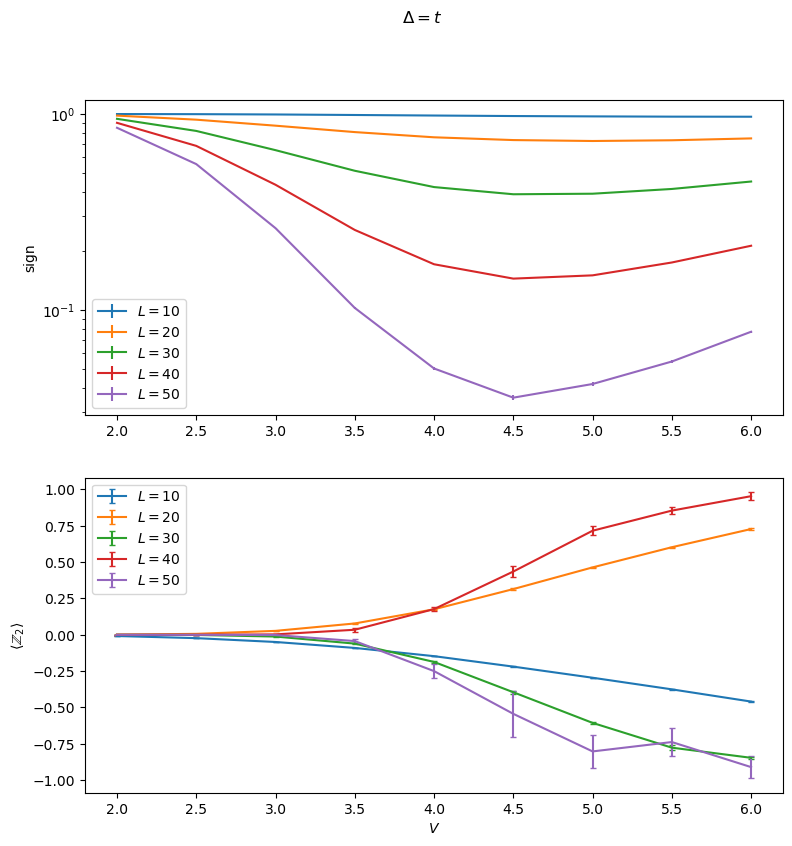

In [12]:
Vs = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

# Vs = np.arange(1.0, 7.5, 0.5)
# Ls = np.arange(8, 19, 2)

fig, axs = plt.subplots(2, 1, figsize=(9, 9))

for L in [10, 20, 30, 40, 50]:
    signs = []
    signsStd = []
    z2PlusSigns = []
    z2PlusSignsStd = []
    z2MinusSigns = []
    z2MinusSignsStd = []
    for V in Vs:
        # print("L = {}, V = {}".format(L, V))
        # obs, params = getChainDataFromFile(L, V)
        # r = biningAndAnalysis(obs)
        r = data[(L, V)]
        signs.append(r["obsSign"][0])
        signsStd.append(r["obsSign"][1])
        z2PlusSigns.append(r["obsZ2"][0])
        z2PlusSignsStd.append(r["obsZ2"][1])

    axs[0].errorbar(Vs, signs, yerr=signsStd, label=r"$L = {}$".format(L))

    axs[1].errorbar(Vs, z2PlusSigns, yerr=z2PlusSignsStd, label=r"$L = {}$".format(L), capsize=2)

axs[0].set_ylabel(r"sign")
    # axs[0].set_ylim(0, 1.0)
axs[0].set_yscale("log")
axs[0].legend()
axs[1].set_ylabel(r"$\left<\mathbb{Z}_2 \right>$")
# axs[1].set_ylim(0, 1.0)
# axs[1].set_yscale("log")
axs[1].set_xlabel(r"$V$")
axs[1].legend()

fig.suptitle("$\Delta = t$")
plt.legend()
plt.show()



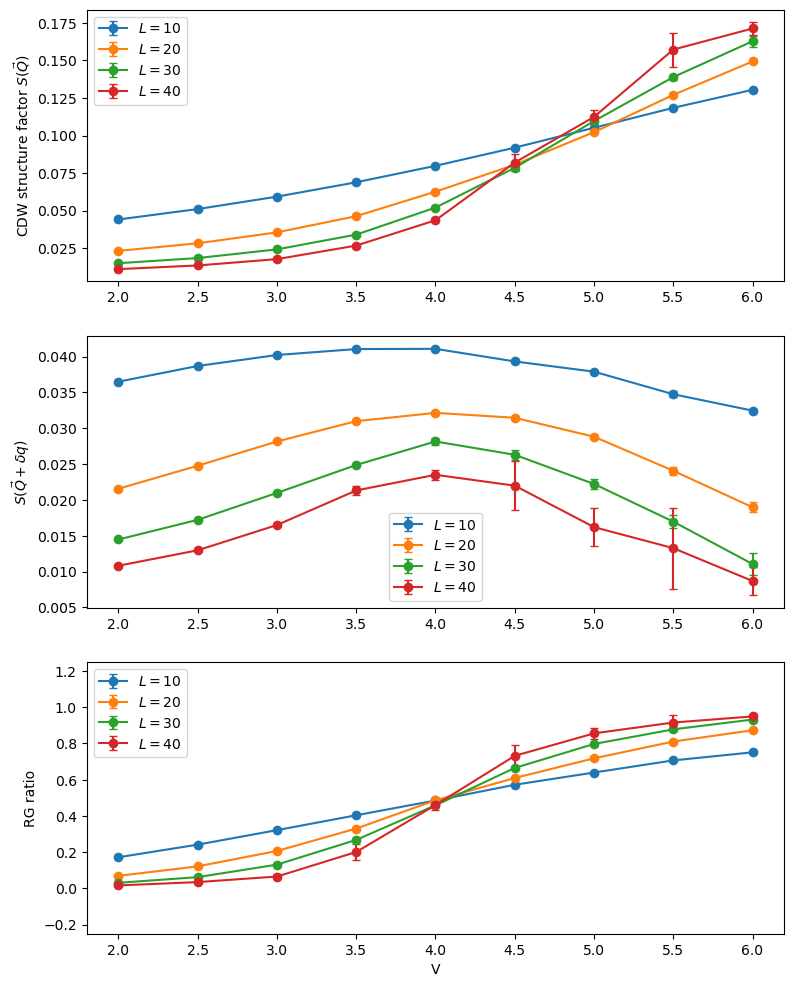

In [13]:
Vs = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

fig, axs = plt.subplots(3, 1, figsize=(9, 12))

cut = len(Vs)

# xs = np.arange(0.0, 7.0, 0.01)
# f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
# ys = np.array([f(x) for x in xs])
# axs[1].plot(xs, ys, label="exact")
# axs[2].plot(xs, -ys, label="exact")

for L in [10, 20, 30, 40]:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    cdw = []
    cdwStd = []

    cdwq = []
    cdwqStd = []

    rgRatio = []
    rgRatioStd = []

    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        cdw.append(r["obsCDW"][0])
        cdwStd.append(r["obsCDW"][1])
        cdwq.append(r["obsCDWq"][0])
        cdwqStd.append(r["obsCDWq"][1])
        rgRatio.append(r["rgRatio"][0])
        rgRatioStd.append(r["rgRatio"][1])


    axs[0].errorbar(Vs, -np.array(cdw), yerr=cdwStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[1].errorbar(Vs, -np.array(cdwq), yerr=cdwqStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[2].errorbar(Vs, 1.0 - np.array(rgRatio), yerr=rgRatioStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    # if L in [8, 12, 16]:
    #     axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    
    # if L in [10, 14, 18]:
    #     axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    # axs[2].set_yscale("log")

axs[0].set_ylabel(r"CDW structure factor $S(\vec{Q})$")
axs[0].legend()

axs[1].set_ylabel(r"$S(\vec{Q} + \delta q)$")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"RG ratio")
axs[2].set_xlabel(r"V")
axs[2].set_ylim(-0.25, 1.25)
# axs[2].legend()
plt.legend()
plt.show()


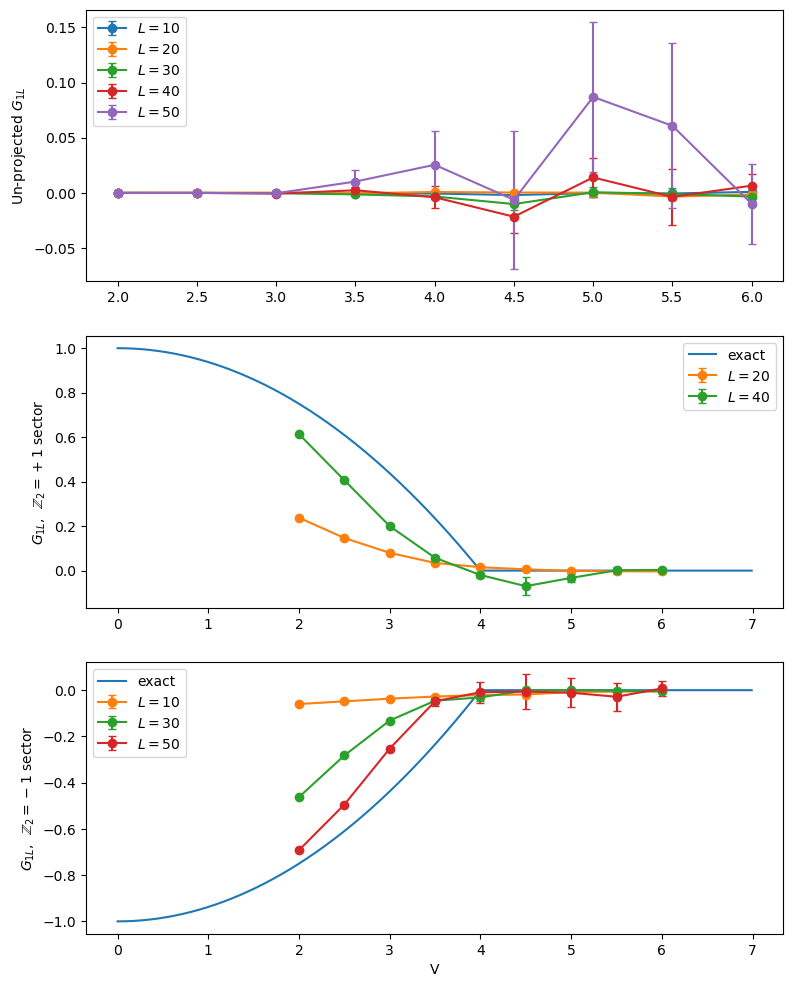

In [19]:
Vs = np.arange(2.0, 6.5, 0.5)

fig, axs = plt.subplots(3, 1, figsize=(9, 12))

cut = len(Vs)

xs = np.arange(0.0, 7.0, 0.01)
f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
ys = np.array([f(x) for x in xs])
axs[1].plot(xs, ys, label="exact")
axs[2].plot(xs, -ys, label="exact")

for L in [10, 20, 30, 40, 50]:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    eCorr = []
    eCorrStd = []

    eCorrZ2Plus = []
    eCorrZ2PlusStd = []
    eCorrZ2Minus = []
    eCorrZ2MinusStd = []
    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        eCorr.append(r["obsEdgeCorrelator"][0])
        eCorrStd.append(r["obsEdgeCorrelator"][1])
        eCorrZ2Plus.append(r["obsEdgeCorrelatorPlus"][0])
        eCorrZ2PlusStd.append(r["obsEdgeCorrelatorPlus"][1])
        eCorrZ2Minus.append(r["obsEdgeCorrelatorMinus"][0])
        eCorrZ2MinusStd.append(r["obsEdgeCorrelatorMinus"][1])

    
        
    eCorrStd = np.clip(np.abs(eCorrStd), 0, 1)
    eCorrZ2PlusStd = np.clip(np.abs(eCorrZ2PlusStd), 0, 1)
    eCorrZ2MinusStd = np.clip(np.abs(eCorrZ2MinusStd), 0, 1)


    axs[0].errorbar(Vs, eCorr, yerr=eCorrStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    if L in [20, 40]:
        axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), capsize=3, marker='o')
    
    if L in [10, 30, 50]:
        axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), capsize=3, marker='o')
    # axs[2].set_yscale("log")

axs[0].set_ylabel(r"Un-projected $G_{1L}$")
axs[0].legend()

axs[1].set_ylabel(r"$G_{1L}$,  $\mathbb{Z}_2=+1$ sector")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"$G_{1L}$,  $\mathbb{Z}_2=-1$ sector")
axs[2].set_xlabel(r"V")
# axs[2].set_ylim(-1, 1.0)
axs[2].legend()
plt.legend()
plt.show()


# $L_\tau = 2.0 * L, \, \Delta = t$

In [21]:
data = [((10, 2.0), {'obsSign': (0.9906325000000001, 0.00015448454988531782), 'obsZ2': (-0.0395963944552165, 0.00029032388678130246), 'obsZ2Plus': (0.4802018027723917, 0.00014516194339063307), 'obsZ2Minus': (0.5197981972276082, 0.0001451619433906293), 'obsEdgeCorrelator': (-0.003277802760926767, 0.0001646286276639172), 'obsEdgeCorrelatorPlus': (0.4864849640336474, 0.001482655405258737), 'obsEdgeCorrelatorMinus': (-0.4557321683395423, 0.0014618422934178834), 'obsCDW': (-0.045885900311193925, 4.26327878248322e-05), 'obsCDWM4': (0.005379942333592794, 8.833393259835514e-06), 'obsBinning': (2.555165918153797, 0.0011047169922646547), 'obsCDWq': (-0.036826778689053326, 1.5077065605748466e-05), 'rgRatio': (0.8025728697156317, 0.0006660874366764844)}), ((10, 2.5), {'obsSign': (0.9701575, 0.0002778156707465107), 'obsZ2': (-0.10156253051337037, 0.0004200061599224131), 'obsZ2Plus': (0.44921873474331486, 0.00021000307996114532), 'obsZ2Minus': (0.5507812652566851, 0.0002100030799611069), 'obsEdgeCorrelator': (-0.006688838845547365, 0.00041513300929031503), 'obsEdgeCorrelatorPlus': (0.3962908648336875, 0.0011814664044754767), 'obsEdgeCorrelatorMinus': (-0.33536020810622313, 0.0009333047943552229), 'obsCDW': (-0.054922757148683506, 8.298273602363862e-05), 'obsCDWM4': (0.007355105048558251, 1.947415827893997e-05), 'obsBinning': (2.4382836024173957, 0.0017663125568352215), 'obsCDWq': (-0.038871283701127454, 2.797190490974493e-05), 'rgRatio': (0.7077445803902699, 0.0011714161035221173)}), ((10, 3.0), {'obsSign': (0.9410750000000001, 0.00037985007915674343), 'obsZ2': (-0.20327127274053777, 0.001291761098882857), 'obsZ2Plus': (0.398364363629731, 0.000645880549441459), 'obsZ2Minus': (0.6016356363702687, 0.0006458805494413506), 'obsEdgeCorrelator': (-0.012484637032793476, 0.0008964122108074785), 'obsEdgeCorrelatorPlus': (0.3133165868413529, 0.0018030887755510255), 'obsEdgeCorrelatorMinus': (-0.22820922079910874, 0.0011157904713447197), 'obsCDW': (-0.06673664957873213, 0.0003020135082449357), 'obsCDWM4': (0.010134341307048026, 6.711011780622212e-05), 'obsBinning': (2.27544701526896, 0.006891003075733657), 'obsCDWq': (-0.03958667601890729, 9.269067780035142e-05), 'rgRatio': (0.5931774581393524, 0.003883102587671087)}), ((10, 3.5), {'obsSign': (0.9138725000000001, 0.00046242804622153915), 'obsZ2': (-0.33313575312465876, 0.0016608013630941315), 'obsZ2Plus': (0.3334321234376706, 0.0008304006815470382), 'obsZ2Minus': (0.6665678765623294, 0.0008304006815471496), 'obsEdgeCorrelator': (-0.013291755307921562, 0.0011397790361365127), 'obsEdgeCorrelatorPlus': (0.2469644099076862, 0.002730226641619896), 'obsEdgeCorrelatorMinus': (-0.14347769550882403, 0.001492857861707646), 'obsCDW': (-0.08185404685058417, 0.00046429456914176304), 'obsCDWM4': (0.014003611203448526, 0.00012727394932940224), 'obsBinning': (2.0900647146521396, 0.011525190517664376), 'obsCDWq': (-0.03904097509635184, 0.00014557056634785184), 'rgRatio': (0.4769584001983911, 0.002969952972658556)}), ((10, 4.0), {'obsSign': (0.8928625, 0.0005113178489955071), 'obsZ2': (-0.47229388987610915, 0.0013248724582165313), 'obsZ2Plus': (0.2638530550619454, 0.000662436229108315), 'obsZ2Minus': (0.7361469449380548, 0.0006624362291081097), 'obsEdgeCorrelator': (-0.01593479900534009, 0.001174899862497709), 'obsEdgeCorrelatorPlus': (0.18499157969604946, 0.003238405133969079), 'obsEdgeCorrelatorMinus': (-0.08795172333632667, 0.0015300533081922475), 'obsCDW': (-0.10000367997084689, 0.0009160993223104426), 'obsCDWM4': (0.018698991837412974, 0.00023561584923110474), 'obsBinning': (1.8697615747692848, 0.013262679408377215), 'obsCDWq': (-0.03671308725124575, 0.0002684445403856872), 'rgRatio': (0.36711736702832953, 0.004618503112278687)}), ((10, 4.5), {'obsSign': (0.8829125, 0.0005354383766008365), 'obsZ2': (-0.6084427867246155, 0.0015654533337740959), 'obsZ2Plus': (0.1957786066376923, 0.0007827266668869516), 'obsZ2Minus': (0.8042213933623078, 0.0007827266668870073), 'obsEdgeCorrelator': (-0.01332080902859298, 0.0016014783124514555), 'obsEdgeCorrelatorPlus': (0.14058259547296995, 0.004726554206957871), 'obsEdgeCorrelatorMinus': (-0.05078685299599928, 0.0018339662087929456), 'obsCDW': (-0.11750720811195182, 0.0005819975495086711), 'obsCDWM4': (0.02346074926248807, 0.00019213834930474535), 'obsBinning': (1.6990762225445886, 0.007117115723169666), 'obsCDWq': (-0.03326272715052936, 0.0002211688841138284), 'rgRatio': (0.2830696761462983, 0.0030136287770233866)}), ((10, 5.0), {'obsSign': (0.8828900000000001, 0.0005254907346456103), 'obsZ2': (-0.7238732352686258, 0.001805427104457404), 'obsZ2Plus': (0.13806338236568713, 0.0009027135522287788), 'obsZ2Minus': (0.8619366176343128, 0.0009027135522285503), 'obsEdgeCorrelator': (-0.01062663186794137, 0.0015071512165520465), 'obsEdgeCorrelatorPlus': (0.1118171678367584, 0.007204468661274542), 'obsEdgeCorrelatorMinus': (-0.03023944873503522, 0.0017390380808834651), 'obsCDW': (-0.13843827036552056, 0.0010934733609514909), 'obsCDWM4': (0.029082537628536905, 0.00032084137575399946), 'obsBinning': (1.5174694984735848, 0.00868968832113481), 'obsCDWq': (-0.02808364823671064, 0.00047615465898933576), 'rgRatio': (0.2028604429431191, 0.004861496662756307)}), ((10, 5.5), {'obsSign': (0.8886525000000001, 0.0005243280453908598), 'obsZ2': (-0.8135305065608116, 0.0019033604013506903), 'obsZ2Plus': (0.09323474671959416, 0.000951680200675314), 'obsZ2Minus': (0.9067652532804059, 0.000951680200675293), 'obsEdgeCorrelator': (-0.008642758059829498, 0.0014400574645193878), 'obsEdgeCorrelatorPlus': (0.09007313023520076, 0.012313808690762727), 'obsEdgeCorrelatorMinus': (-0.018792849753505477, 0.0017146541859352133), 'obsCDW': (-0.15544002075382551, 0.0012069054107396973), 'obsCDWM4': (0.03360625534767339, 0.00031235479212322285), 'obsBinning': (1.3908952820369034, 0.009561478536295097), 'obsCDWq': (-0.02383337278872378, 0.0005567312580641501), 'rgRatio': (0.15332842376258266, 0.0045473393267411516)}), ((10, 6.0), {'obsSign': (0.8970250000000001, 0.0004975687840455611), 'obsZ2': (-0.8741480455102517, 0.00202772469440133), 'obsZ2Plus': (0.06292597724487418, 0.00101386234720078), 'obsZ2Minus': (0.9370740227551257, 0.0010138623472004762), 'obsEdgeCorrelator': (-0.007774182975484843, 0.0016172135694337275), 'obsEdgeCorrelatorPlus': (0.006218808076140729, 0.04199754252909248), 'obsEdgeCorrelatorMinus': (-0.008713832398702107, 0.0026027508589960154), 'obsCDW': (-0.16991348828729133, 0.0016768148593396576), 'obsCDWM4': (0.037787529156855085, 0.0004335982593979327), 'obsBinning': (1.3088587696795695, 0.011584361787889925), 'obsCDWq': (-0.019294391693666764, 0.0009075201403414132), 'rgRatio': (0.11355421614496303, 0.006421624865071058)}), ((20, 2.0), {'obsSign': (0.9480900000000001, 0.0003619017257590772), 'obsZ2': (0.0029013656454053675, 7.56983476701681e-05), 'obsZ2Plus': (0.5014506828227027, 3.784917383499193e-05), 'obsZ2Minus': (0.49854931717729734, 3.784917383504706e-05), 'obsEdgeCorrelator': (0.00042329580900697623, 6.841910697660083e-05), 'obsEdgeCorrelatorPlus': (0.6866062356312445, 0.0007978477815084731), 'obsEdgeCorrelatorMinus': (-0.6897529653144087, 0.000796050869980387), 'obsCDW': (-0.02216348473406419, 1.4138116512434914e-05), 'obsCDWM4': (0.0013709779154533722, 1.6487040547482224e-06), 'obsBinning': (2.7909648636977065, 0.0006265727610835593), 'obsCDWq': (-0.020810421352480724, 1.0359423041073558e-05), 'rgRatio': (0.938950783346751, 0.00019413631305741574)}), ((20, 2.5), {'obsSign': (0.8313275000000001, 0.000634679108027032), 'obsZ2': (0.021018736384628207, 0.0003405356398166204), 'obsZ2Plus': (0.5105093681923141, 0.00017026781990824879), 'obsZ2Minus': (0.48949063180768587, 0.00017026781990836), 'obsEdgeCorrelator': (0.002189798754872383, 0.00026968509816660416), 'obsEdgeCorrelatorPlus': (0.5111297270870778, 0.0012790196763883168), 'obsEdgeCorrelatorMinus': (-0.528604019099065, 0.0013610609763719025), 'obsCDW': (-0.026961088733516058, 3.6756554737670965e-05), 'obsCDWM4': (0.0020088607441912532, 1.9900862838349247e-05), 'obsBinning': (2.7635987046338766, 0.025738770110025334), 'obsCDWq': (-0.02387356329401811, 2.916063152637634e-05), 'rgRatio': (0.8854821677513925, 0.001057018459138325)}), ((20, 3.0), {'obsSign': (0.6759449999999999, 0.0008585302884678142), 'obsZ2': (0.09382101785742152, 0.0012132312910659601), 'obsZ2Plus': (0.546910508928711, 0.0006066156455329363), 'obsZ2Minus': (0.4530894910712894, 0.0006066156455328914), 'obsEdgeCorrelator': (0.005435392284804623, 0.0009530022709218342), 'obsEdgeCorrelatorPlus': (0.31608794693502956, 0.0023440105709418785), 'obsEdgeCorrelatorMinus': (-0.3695438339281772, 0.0027653173084936774), 'obsCDW': (-0.03462321966918521, 0.00015713984747199366), 'obsCDWM4': (0.003159948003650218, 2.7014268529073962e-05), 'obsBinning': (2.6359977400010854, 0.009138906943803118), 'obsCDWq': (-0.027381336950390904, 9.43592805300663e-05), 'rgRatio': (0.7908373991181382, 0.003136528886887231)}), ((20, 3.5), {'obsSign': (0.5421075000000001, 0.000971793006178121), 'obsZ2': (0.2658392059955086, 0.005565653174018474), 'obsZ2Plus': (0.6329196029977543, 0.0027828265870092276), 'obsZ2Minus': (0.3670803970022457, 0.0027828265870092446), 'obsEdgeCorrelator': (0.009360130508780859, 0.0022484855490440747), 'obsEdgeCorrelatorPlus': (0.14007819782539802, 0.0032930474634248587), 'obsEdgeCorrelatorMinus': (-0.21602381372119062, 0.005301085961710422), 'obsCDW': (-0.05021264330546763, 0.000770447097604912), 'obsCDWM4': (0.005995831980600077, 0.00018142886258872302), 'obsBinning': (2.3780626038360846, 0.045349060185456744), 'obsCDWq': (-0.029097642609882027, 0.0004973190056610625), 'rgRatio': (0.5794883856478757, 0.014320653113258818)}), ((20, 4.0), {'obsSign': (0.4621275, 0.0010173162563373948), 'obsZ2': (0.504335029281751, 0.005041698986516186), 'obsZ2Plus': (0.7521675146408754, 0.0025208494932581716), 'obsZ2Minus': (0.24783248535912453, 0.0025208494932581166), 'obsEdgeCorrelator': (0.012954449019255767, 0.003578438492211338), 'obsEdgeCorrelatorPlus': (0.05099525023999797, 0.003622298064224447), 'obsEdgeCorrelatorMinus': (-0.10249875666093015, 0.012744711459133206), 'obsCDW': (-0.0724331638884092, 0.0009938645750492575), 'obsCDWM4': (0.010363529935828038, 0.00022088829074000838), 'obsBinning': (1.9752987859983469, 0.02402421463570927), 'obsCDWq': (-0.029267796179170406, 0.0004474440359696413), 'rgRatio': (0.40406625444037275, 0.010076588097895307)}), ((20, 4.5), {'obsSign': (0.44140250000000003, 0.0010323001850231896), 'obsZ2': (0.7248523734277902, 0.0047731849050197655), 'obsZ2Plus': (0.862426186713895, 0.002386592452509909), 'obsZ2Minus': (0.13757381328610496, 0.0023865924525098858), 'obsEdgeCorrelator': (0.00616555723167687, 0.004081780686755697), 'obsEdgeCorrelatorPlus': (0.0168564083928552, 0.0038998802577932977), 'obsEdgeCorrelatorMinus': (-0.06085352211372879, 0.019164005929336998), 'obsCDW': (-0.10153927327882432, 0.0015723398042335648), 'obsCDWM4': (0.016822795757063403, 0.00030766134547947926), 'obsBinning': (1.6316615592110475, 0.026976564002590638), 'obsCDWq': (-0.02459097544170858, 0.0008665690797609407), 'rgRatio': (0.24218193146196743, 0.011476335272588262)}), ((20, 5.0), {'obsSign': (0.45389750000000006, 0.0010001329249667724), 'obsZ2': (0.881809864924591, 0.006869954449518934), 'obsZ2Plus': (0.9409049324622955, 0.0034349772247594095), 'obsZ2Minus': (0.059095067537704396, 0.0034349772247594884), 'obsEdgeCorrelator': (0.010166406087331289, 0.006591720370554862), 'obsEdgeCorrelatorPlus': (0.008056237097606932, 0.005947638408104523), 'obsEdgeCorrelatorMinus': (0.04376435312351149, 0.07029825395403834), 'obsCDW': (-0.13136466496040594, 0.0018602198734555269), 'obsCDWM4': (0.024081906091232074, 0.00042771799712304883), 'obsBinning': (1.3955125324284736, 0.0193688183674895), 'obsCDWq': (-0.020807221299518085, 0.0008175008210022705), 'rgRatio': (0.15839284336777015, 0.007908221490476715)}), ((20, 5.5), {'obsSign': (0.48803750000000007, 0.000989806524771874), 'obsZ2': (0.950411142759516, 0.007588537225932499), 'obsZ2Plus': (0.975205571379758, 0.003794268612966272), 'obsZ2Minus': (0.024794428620241962, 0.003794268612966188), 'obsEdgeCorrelator': (0.019062116813275735, 0.011691982241719454), 'obsEdgeCorrelatorPlus': (0.020985322250973673, 0.01093800375616937), 'obsEdgeCorrelatorMinus': (-0.05658088033961337, 0.10119169912824294), 'obsCDW': (-0.15618876809588234, 0.0022859284694909357), 'obsCDWM4': (0.0292099316672831, 0.001319788239243073), 'obsBinning': (1.1973771795952763, 0.06496890133458985), 'obsCDWq': (-0.014441637831686163, 0.0010485659362341995), 'rgRatio': (0.09246272888696769, 0.007829744664419635)}), ((20, 6.0), {'obsSign': (0.5315522675612501, 0.0009584856094020344), 'obsZ2': (0.974632092599537, 0.004576743124680888), 'obsZ2Plus': (0.9873160462997683, 0.0022883715623404355), 'obsZ2Minus': (0.012683953700231503, 0.0022883715623403626), 'obsEdgeCorrelator': (-0.0001529330218237967, 0.0035809285241058977), 'obsEdgeCorrelatorPlus': (-0.0031845855424908957, 0.003290956502658656), 'obsEdgeCorrelatorMinus': (0.23583113741256442, 0.1881008577906044), 'obsCDW': (-0.17312547280767718, 0.0018057068913499576), 'obsCDWM4': (0.03621349249186629, 0.0006866226347382619), 'obsBinning': (1.2082268044764721, 0.015015709821767266), 'obsCDWq': (-0.01129895082239973, 0.0008420653404865066), 'rgRatio': (0.06526452403261096, 0.005272852711297061)}), ((30, 2.0), {'obsSign': (0.8874725000000001, 0.0005224563025194527), 'obsZ2': (-0.00016474189487283392, 2.5238291376592967e-05), 'obsZ2Plus': (0.4999176290525636, 1.2619145688343387e-05), 'obsZ2Minus': (0.5000823709474363, 1.2619145688204612e-05), 'obsEdgeCorrelator': (-1.6344630594826388e-05, 2.4547162365473223e-05), 'obsEdgeCorrelatorPlus': (0.7409907636603582, 0.0009889159823184808), 'obsEdgeCorrelatorMinus': (-0.7407793433065479, 0.0009910797958766827), 'obsCDW': (-0.014591728355253417, 8.310527241549961e-06), 'obsCDWM4': (0.0006094044644849945, 6.731094748393009e-07), 'obsBinning': (2.86214847606325, 0.0004778630519073664), 'obsCDWq': (-0.014187578281324385, 6.894505779921151e-06), 'rgRatio': (0.972302796214814, 0.00013563971412161596)}), ((30, 2.5), {'obsSign': (0.6547, 0.0008563179374826188), 'obsZ2': (-0.0034698722911256858, 0.00020934104167774658), 'obsZ2Plus': (0.4982650638544373, 0.00010467052083890346), 'obsZ2Minus': (0.5017349361455629, 0.00010467052083890438), 'obsEdgeCorrelator': (-0.000812212670168653, 0.00017508105199958996), 'obsEdgeCorrelatorPlus': (0.5833747435654043, 0.0015980851357830874), 'obsEdgeCorrelatorMinus': (-0.580959079237178, 0.0015889152825778506), 'obsCDW': (-0.017648106669031192, 4.9671365678278916e-05), 'obsCDWM4': (0.0008852038269957653, 8.231430435395448e-06), 'obsBinning': (2.8421503030933457, 0.01200134728387971), 'obsCDWq': (-0.016682199646958912, 3.655738438011462e-05), 'rgRatio': (0.9452685188165248, 0.0007933523870448095)}), ((30, 3.0), {'obsSign': (0.3898025, 0.0010533975176397672), 'obsZ2': (-0.032477681101396164, 0.0016791608908842133), 'obsZ2Plus': (0.48376115944930187, 0.0008395804454421009), 'obsZ2Minus': (0.5162388405506981, 0.0008395804454420925), 'obsEdgeCorrelator': (-0.0023179828771115567, 0.0012103010551659846), 'obsEdgeCorrelatorPlus': (0.3967661443817109, 0.004433562938687953), 'obsEdgeCorrelatorMinus': (-0.3762948807363968, 0.004379892371806861), 'obsCDW': (-0.022670557404187844, 0.00015011166767882334), 'obsCDWM4': (0.001431848372647548, 1.956407773820739e-05), 'obsBinning': (2.785945600194808, 0.016818726300077445), 'obsCDWq': (-0.020125721186624448, 0.00010756167571421265), 'rgRatio': (0.8877470854210162, 0.005842232117663876)}), ((30, 3.5), {'obsSign': (0.20748500000000003, 0.0011105352352830547), 'obsZ2': (-0.19441465204739466, 0.010557189486403915), 'obsZ2Plus': (0.40279267397630264, 0.005278594743201957), 'obsZ2Minus': (0.5972073260236972, 0.005278594743202066), 'obsEdgeCorrelator': (-0.011950534179809753, 0.006688225529954117), 'obsEdgeCorrelatorPlus': (0.2149488336670645, 0.012611174917482334), 'obsEdgeCorrelatorMinus': (-0.16498516476492472, 0.009055793946332522), 'obsCDW': (-0.034043561543706774, 0.000755299136603937), 'obsCDWM4': (0.0029405565273047567, 9.834376472613078e-05), 'obsBinning': (2.5372284012834654, 0.05418107757626538), 'obsCDWq': (-0.022914261989622937, 0.000494491812154584), 'rgRatio': (0.6730865554319805, 0.022162239301215757)}), ((30, 4.0), {'obsSign': (0.13044749062250002, 0.0011061830283697412), 'obsZ2': (-0.484140406281715, 0.01925698007799026), 'obsZ2Plus': (0.25792979685914236, 0.009628490038995094), 'obsZ2Minus': (0.7420702031408575, 0.009628490038995099), 'obsEdgeCorrelator': (-0.017998308871102812, 0.017555626912015593), 'obsEdgeCorrelatorPlus': (0.1008536755542266, 0.050340139678409966), 'obsEdgeCorrelatorMinus': (-0.0593090399410673, 0.016355627595721497), 'obsCDW': (-0.058862442254437694, 0.0026664502267757335), 'obsCDWM4': (0.007042994593963234, 0.00048295335423661654), 'obsBinning': (2.032735488361168, 0.11398333867931366), 'obsCDWq': (-0.02711563657703423, 0.0013961873826861073), 'rgRatio': (0.4606612360407019, 0.035180431983774574)}), ((30, 4.5), {'obsSign': (0.10920497451125001, 0.0011083604374105265), 'obsZ2': (-0.8638839105319173, 0.06184054724606259), 'obsZ2Plus': (0.0680580447340414, 0.030920273623031236), 'obsZ2Minus': (0.9319419552659586, 0.030920273623031305), 'obsEdgeCorrelator': (-0.016743568812808095, 0.019374203318849682), 'obsEdgeCorrelatorPlus': (0.038316361910316434, 0.2267526983241471), 'obsEdgeCorrelatorMinus': (-0.020764426957558445, 0.014715288547746373), 'obsCDW': (-0.10203026846261694, 0.006955629793902429), 'obsCDWM4': (0.01628140210460237, 0.0015856796864961945), 'obsBinning': (1.5639896941353801, 0.11694193956363433), 'obsCDWq': (-0.01670961450989741, 0.0038948882315455883), 'rgRatio': (0.16377148769272237, 0.04773005965210941)}), ((30, 5.0), {'obsSign': (0.12405247923750001, 0.0011081044743947767), 'obsZ2': (-0.9730077121596069, 0.027993144277231746), 'obsZ2Plus': (0.013496143920196477, 0.01399657213861586), 'obsZ2Minus': (0.9865038560798034, 0.013996572138615927), 'obsEdgeCorrelator': (-0.03508560824839779, 0.021914886527932845), 'obsEdgeCorrelatorPlus': (-1.0065860284719284, 1.2488831564131535), 'obsEdgeCorrelatorMinus': (-0.021796126654818473, 0.017439762628974478), 'obsCDW': (-0.13410075781705183, 0.012645684771069497), 'obsCDWM4': (0.020365017735033502, 0.002234673829045601), 'obsBinning': (1.1324598225983846, 0.12322649619967811), 'obsCDWq': (-0.013808107484807515, 0.0076692787154946825), 'rgRatio': (0.10296873666334064, 0.06336950727770495)}), ((30, 5.5), {'obsSign': (0.15301461892374998, 0.001099575751603831), 'obsZ2': (-0.9882345875051036, 0.026792327654609104), 'obsZ2Plus': (0.005882706247448298, 0.013396163827304537), 'obsZ2Minus': (0.9941172937525519, 0.013396163827304512), 'obsEdgeCorrelator': (-0.01025870593560055, 0.01950258061098574), 'obsEdgeCorrelatorPlus': (-0.6659403370663145, 2.267281026756501), 'obsEdgeCorrelatorMinus': (-0.006380423554909295, 0.014026302518450738), 'obsCDW': (-0.15936364804376607, 0.012466981787011758), 'obsCDWM4': (0.019634290724266562, 0.011711022670853178), 'obsBinning': (0.7731004738894031, 0.42621835684730885), 'obsCDWq': (-0.018279598171440037, 0.0071789700809128994), 'rgRatio': (0.11470405813770378, 0.049923359258209475)}), ((30, 6.0), {'obsSign': (0.19364957409375003, 0.0010962618591034462), 'obsZ2': (-1.0249292675384312, 0.011736747793939661), 'obsZ2Plus': (-0.0124646337692155, 0.005868373896969895), 'obsZ2Minus': (1.0124646337692154, 0.00586837389696977), 'obsEdgeCorrelator': (-0.01592166084552333, 0.011936178142300457), 'obsEdgeCorrelatorPlus': (0.9521831327388288, 0.6797307710479371), 'obsEdgeCorrelatorMinus': (-0.004003445990008438, 0.0096428075293521), 'obsCDW': (-0.1784313990422344, 0.00823609862760138), 'obsCDWM4': (0.035372394864667644, 0.0017839284921494169), 'obsBinning': (1.1110204397258978, 0.06686870362802298), 'obsCDWq': (-0.010840919343471278, 0.00502970108176854), 'rgRatio': (0.060756797656265314, 0.02880237769506012)}), ((40, 2.0), {'obsSign': (0.8112, 0.0006601511025021244), 'obsZ2': (9.09755079146669e-06, 3.991793208772069e-06), 'obsZ2Plus': (0.5000045487753958, 1.995896604336403e-06), 'obsZ2Minus': (0.49999545122460426, 1.9958966044620897e-06), 'obsEdgeCorrelator': (4.065568824288331e-06, 2.9094722006514206e-06), 'obsEdgeCorrelatorPlus': (0.7495835182401115, 0.0013900551456282192), 'obsEdgeCorrelatorMinus': (-0.7495890259008015, 0.001389719039041615), 'obsCDW': (-0.010904593286183867, 8.464205266814406e-06), 'obsCDWM4': (0.00034438142857878894, 4.973312463392427e-07), 'obsBinning': (2.896148182821549, 0.0006289564479990209), 'obsCDWq': (-0.010730507892069592, 7.890399742444377e-06), 'rgRatio': (0.9840355903699451, 6.620232920842194e-05)}), ((40, 2.5), {'obsSign': (0.47021250000000003, 0.000991976490644467), 'obsZ2': (0.0006759201757685416, 0.0002081302983954768), 'obsZ2Plus': (0.5003379600878843, 0.00010406514919763495), 'obsZ2Minus': (0.4996620399121157, 0.00010406514919778972), 'obsEdgeCorrelator': (0.00020766439092402726, 0.00017351467894930714), 'obsEdgeCorrelatorPlus': (0.601924608640507, 0.0021937094832105175), 'obsEdgeCorrelatorMinus': (-0.6023232552855123, 0.0021920198106028647), 'obsCDW': (-0.013152980912423354, 2.3471810747837903e-05), 'obsCDWM4': (0.0004969886948931916, 1.8606810065539474e-06), 'obsBinning': (2.8727519621792386, 0.0036539013964137666), 'obsCDWq': (-0.012738490846082326, 1.9904899507848253e-05), 'rgRatio': (0.9684869864573414, 0.00039119955517830194)}), ((40, 3.0), {'obsSign': (0.18023750000000005, 0.0010842260572010872), 'obsZ2': (0.007907908763751562, 0.0030228443034289194), 'obsZ2Plus': (0.5039539543818757, 0.001511422151714367), 'obsZ2Minus': (0.49604604561812404, 0.0015114221517144347), 'obsEdgeCorrelator': (-0.0025350843804887455, 0.002484965984151166), 'obsEdgeCorrelatorPlus': (0.4225396369852872, 0.009337950064210374), 'obsEdgeCorrelatorMinus': (-0.4343862977465242, 0.009487401084637092), 'obsCDW': (-0.016731887973623873, 0.00016561949059747566), 'obsCDWM4': (0.0007829055408993685, 1.4888730527789876e-05), 'obsBinning': (2.7965299061218816, 0.02463686977392981), 'obsCDWq': (-0.015716511076177105, 0.00012780196244047015), 'rgRatio': (0.9393148683241923, 0.006086293545884333)}), ((40, 3.5), {'obsSign': (0.05076999915625, 0.0011222280920365022), 'obsZ2': (0.15877937453146843, 0.038348047711600275), 'obsZ2Plus': (0.5793896872657343, 0.019174023855800013), 'obsZ2Minus': (0.4206103127342658, 0.01917402385580025), 'obsEdgeCorrelator': (0.0020646420222663535, 0.02935166905186439), 'obsEdgeCorrelatorPlus': (0.23122173558035986, 0.05630100827576901), 'obsEdgeCorrelatorMinus': (-0.3135987870367353, 0.09809054148380421), 'obsCDW': (-0.024244208096568437, 0.002386926533288148), 'obsCDWM4': (0.0016095284127219925, 0.00024372306773275628), 'obsBinning': (2.738311859648193, 0.320466523739436), 'obsCDWq': (-0.020834700029916168, 0.001421386251146882), 'rgRatio': (0.8593691098834918, 0.09835604653726054)}), ((40, 4.0), {'obsSign': (0.018652488580000005, 0.001125788770156074), 'obsZ2': (0.3085198742246196, 0.15248972366115243), 'obsZ2Plus': (0.6542599371123097, 0.07624486183057627), 'obsZ2Minus': (0.3457400628876902, 0.07624486183057615), 'obsEdgeCorrelator': (0.11654424900095076, 0.15147879034806516), 'obsEdgeCorrelatorPlus': (0.030231028242912374, 0.18910383924126326), 'obsEdgeCorrelatorMinus': (0.279880472567236, 0.23944319352247778), 'obsCDW': (-0.026489385987251497, 0.021891525471245857), 'obsCDWM4': (0.003344388737638839, 0.004045318207593715), 'obsBinning': (4.76639411245466, 4.932717486810142), 'obsCDWq': (-0.0393382127293374, 0.01702237755049798), 'rgRatio': (1.4851935609117464, 1.5137706019594617)}), ((40, 4.5), {'obsSign': (0.015034983063750002, 0.0011163050564713818), 'obsZ2': (0.5586689350666121, 0.2195838793613924), 'obsZ2Plus': (0.779334467533306, 0.10979193968069625), 'obsZ2Minus': (0.2206655324666939, 0.10979193968069613), 'obsEdgeCorrelator': (0.1884434773389278, 0.22676619858227556), 'obsEdgeCorrelatorPlus': (0.16313460705329128, 0.17776790649175067), 'obsEdgeCorrelatorMinus': (0.27783391143514846, 0.7818827961184601), 'obsCDW': (0.019713785006429802, 0.06189885574048382), 'obsCDWM4': (-0.006735104280858488, 0.011333172573001295), 'obsBinning': (-18.793791925089383, 10492.921533286168), 'obsCDWq': (-0.02304497795258962, 0.042841530574522745), 'rgRatio': (-1.1613539103926358, 61.236327873934165)}), ((40, 5.0), {'obsSign': (0.0192674693375, 0.0011089209450145072), 'obsZ2': (0.8575472130249981, 0.15800810612357763), 'obsZ2Plus': (0.9287736065124991, 0.07900405306178886), 'obsZ2Minus': (0.07122639348750105, 0.0790040530617888), 'obsEdgeCorrelator': (0.14687428658878707, 0.15118891463927295), 'obsEdgeCorrelatorPlus': (0.14478718629207402, 0.15126484382093233), 'obsEdgeCorrelatorMinus': (0.17411331526809165, 1.2793658408577866), 'obsCDW': (-0.12124712329227395, 0.05324278846066912), 'obsCDWM4': (0.012540933374532397, 0.013722054243727782), 'obsBinning': (0.853087238897059, 0.8992890129613834), 'obsCDWq': (-0.03872647542521976, 0.03634514376692134), 'rgRatio': (0.31941937525847597, 0.375791892195582)}), ((40, 5.5), {'obsSign': (0.028207440246250003, 0.0011157137401580253), 'obsZ2': (0.999058566085527, 0.08774288799502834), 'obsZ2Plus': (0.9995292830427635, 0.0438714439975141), 'obsZ2Minus': (0.00047071695723646044, 0.043871443997514144), 'obsEdgeCorrelator': (0.04627441148658535, 0.09020454503231579), 'obsEdgeCorrelatorPlus': (0.021614246972185044, 0.06680097430285262), 'obsEdgeCorrelatorMinus': (41.232175080228, 7297.207736445802), 'obsCDW': (-0.14773509585194056, 0.05066256882940749), 'obsCDWM4': (0.035627487368437245, 0.00900646826943563), 'obsBinning': (1.6324068695741687, 0.7789509289682004), 'obsCDWq': (-0.01779312071374694, 0.027558878185111355), 'rgRatio': (0.1204458721466452, 0.19687201374157556)}), ((40, 6.0), {'obsSign': (0.042524837579999995, 0.001105173027424914), 'obsZ2': (1.0773500699195826, 0.06732772222202808), 'obsZ2Plus': (1.0386750349597915, 0.03366386111101397), 'obsZ2Minus': (-0.03867503495979131, 0.033663861111014166), 'obsEdgeCorrelator': (0.04435741969569388, 0.06270816087864205), 'obsEdgeCorrelatorPlus': (0.02751954420526316, 0.045713134424287837), 'obsEdgeCorrelatorMinus': (-0.407891627255068, 1.1612444114692189), 'obsCDW': (-0.15005300033842525, 0.029050785976038353), 'obsCDWM4': (0.02901229876893347, 0.006926953232658088), 'obsBinning': (1.2885325036079485, 0.3792357316708536), 'obsCDWq': (-0.03920220752671173, 0.01370961160139524), 'rgRatio': (0.2612575071637219, 0.11209237117611959)}), ((50, 2.0), {'obsSign': (0.7232999999999999, 0.0007735477018300994), 'obsZ2': (2.003305795549076e-06, 8.976830254311011e-07), 'obsZ2Plus': (0.500001001652898, 4.4884151266906367e-07), 'obsZ2Minus': (0.4999989983471023, 4.4884151273163833e-07), 'obsEdgeCorrelator': (4.37004978626214e-07, 9.014629519375907e-07), 'obsEdgeCorrelatorPlus': (0.750091551771098, 0.0010499357484161514), 'obsEdgeCorrelatorMinus': (-0.7500936830909185, 0.0010499625435524199), 'obsCDW': (-0.008700442727828403, 5.218193995920453e-06), 'obsCDWM4': (0.0002209184225461334, 2.551500312719199e-07), 'obsBinning': (2.9184296465522332, 0.0004097739293051097), 'obsCDWq': (-0.008611303890564978, 4.951612167586248e-06), 'rgRatio': (0.9897546780048472, 3.7807800702071404e-05)}), ((50, 2.5), {'obsSign': (0.30823500000000004, 0.0010738038595269116), 'obsZ2': (-0.00034856477728818325, 0.00014121629240540157), 'obsZ2Plus': (0.4998257176113558, 7.060814620259158e-05), 'obsZ2Minus': (0.500174282388644, 7.060814620275127e-05), 'obsEdgeCorrelator': (-6.570931604639065e-05, 0.00010027519779010607), 'obsEdgeCorrelatorPlus': (0.6101350097998294, 0.0033198433326245436), 'obsEdgeCorrelatorMinus': (-0.6098411876969642, 0.0033128639337324517), 'obsCDW': (-0.01046736258535874, 3.2207085151348285e-05), 'obsCDWM4': (0.0003171026271110933, 1.9871102145553732e-06), 'obsBinning': (2.8941784347878476, 0.005610704921810084), 'obsCDWq': (-0.010259325146647543, 2.8500024550381474e-05), 'rgRatio': (0.980125133179198, 0.0005994305379711473)}), ((50, 3.0), {'obsSign': (0.0645875, 0.0011170526411357672), 'obsZ2': (0.0019459169408308323, 0.007098850440755673), 'obsZ2Plus': (0.5009729584704155, 0.0035494252203777314), 'obsZ2Minus': (0.4990270415295845, 0.00354942522037798), 'obsEdgeCorrelator': (0.005162994167262074, 0.004077243326287277), 'obsEdgeCorrelatorPlus': (0.4305828979480497, 0.03023523545858283), 'obsEdgeCorrelatorMinus': (-0.4219158015820289, 0.03087998044806138), 'obsCDW': (-0.013238572581433555, 0.0003767016275897772), 'obsCDWM4': (0.0004923938458828436, 3.2849535198541494e-05), 'obsBinning': (2.8095079311809594, 0.11354315913929085), 'obsCDWq': (-0.01243531899059466, 0.0002872070454600351), 'rgRatio': (0.9393247954576991, 0.017698200928982607)}), ((50, 3.5), {'obsSign': (0.007124999996250001, 0.0011112757565492782), 'obsZ2': (-0.12568051849858994, 0.22682629117200082), 'obsZ2Plus': (0.43715974075070496, 0.11341314558600037), 'obsZ2Minus': (0.5628402592492949, 0.11341314558600045), 'obsEdgeCorrelator': (0.14182125511851915, 0.19985982284219464), 'obsEdgeCorrelatorPlus': (0.1300219697656839, 0.3534539146885754), 'obsEdgeCorrelatorMinus': (0.15098708118598983, 0.2939315458619227), 'obsCDW': (-0.03194651157906966, 0.016040297114581242), 'obsCDWM4': (0.0009099494628345313, 0.0013190409648725417), 'obsBinning': (0.8916130897652322, 1.5699819803128359), 'obsCDWq': (-0.006722212527167998, 0.006974969920406123), 'rgRatio': (0.2104336977372894, 0.30489120775120626)}), ((50, 4.0), {'obsSign': (0.00274749439125, 0.0010941205996501462), 'obsZ2': (-0.9198953052566651, 1.156207019625643), 'obsZ2Plus': (0.04005234737166758, 0.5781035098128217), 'obsZ2Minus': (0.9599476526283329, 0.5781035098128215), 'obsEdgeCorrelator': (1.662087598945439, 1.2670726190814403), 'obsEdgeCorrelatorPlus': (25.77147213061137, 1593.8107253230512), 'obsEdgeCorrelatorMinus': (0.6782146549972484, 0.9497942676421786), 'obsCDW': (-0.14621940720512988, 0.13348853114644582), 'obsCDWM4': (0.02378695757818322, 0.02224370236124906), 'obsBinning': (1.1128225925173612, 2.1026085380289126), 'obsCDWq': (0.04604882607963182, 0.09109690899316578), 'rgRatio': (-0.3148858902944438, 0.6210248293334306)}), ((50, 4.5), {'obsSign': (3.7505381250000165e-05, 0.0011127717096518967), 'obsZ2': (-157.51545645292973, 45877.357208524874), 'obsZ2Plus': (-78.2577282264649, 22938.678604262448), 'obsZ2Minus': (79.25772822646488, 22938.678604262437), 'obsEdgeCorrelator': (-184.70885843725065, 53867.85026700132), 'obsEdgeCorrelatorPlus': (1.2441343768222506, 1.3932520468222112), 'obsEdgeCorrelatorMinus': (-1.1023637649988232, 1.2435355084654625), 'obsCDW': (-42.77429483815387, 12462.574506883579), 'obsCDWM4': (5.509726407956727, 1605.5959064949466), 'obsBinning': (0.0035493600640483227, 0.10525387808438712), 'obsCDWq': (10.48298878467528, 3065.398284339223), 'rgRatio': (-0.24492404713756305, 0.3206476718409665)}), ((50, 5.0), {'obsSign': (0.00100499107875, 0.0011236464216567413), 'obsZ2': (-0.8716992769246874, 3.102612834408555), 'obsZ2Plus': (0.06415036153765692, 1.5513064172042774), 'obsZ2Minus': (0.9358496384623441, 1.5513064172042774), 'obsEdgeCorrelator': (1.3858159868669768, 3.975542435859018), 'obsEdgeCorrelatorPlus': (19.986426738781386, 1148.190243178741), 'obsEdgeCorrelatorMinus': (0.1537602390683909, 3.4171336269716135), 'obsCDW': (-0.9344031481298769, 1.4128107782576043), 'obsCDWM4': (0.05609957999964932, 0.15348240320884984), 'obsBinning': (0.06425511898926065, 0.1325755965870297), 'obsCDWq': (-0.363471927267774, 0.6705844259555062), 'rgRatio': (0.38908717141352905, 0.8669540682226142)}), ((50, 5.5), {'obsSign': (0.0011972476999999996, 0.0011195900123979398), 'obsZ2': (-3.325798404128813, 3.7599868623559742), 'obsZ2Plus': (-1.1628992020644056, 1.8799934311779865), 'obsZ2Minus': (2.1628992020644064, 1.8799934311779871), 'obsEdgeCorrelator': (-2.303311510846115, 3.0621726564221396), 'obsEdgeCorrelatorPlus': (0.7208786931315747, 1.4574594045114602), 'obsEdgeCorrelatorMinus': (-0.6774203222414085, 0.9516683525441721), 'obsCDW': (-2.375188689165967, 2.3200994478305947), 'obsCDWM4': (0.7351022090051131, 0.7453542208700609), 'obsBinning': (0.13031005463596432, 0.13763910936092), 'obsCDWq': (-0.050323218123641836, 0.4059808665126288), 'rgRatio': (0.02118506455509442, 0.18302272450385612)}), ((50, 6.0), {'obsSign': (0.00442271536, 0.0011077366701840665), 'obsZ2': (-0.26846778687241696, 0.5901208922644974), 'obsZ2Plus': (0.3657661065637916, 0.29506044613224874), 'obsZ2Minus': (0.6342338934362085, 0.2950604461322487), 'obsEdgeCorrelator': (-0.6763946716933625, 0.6527935204363872), 'obsEdgeCorrelatorPlus': (-0.24567612229756577, 1.2024929608754076), 'obsEdgeCorrelatorMinus': (-0.9248009212356095, 1.0191901622033177), 'obsCDW': (0.09385291171300553, 0.2886474267509828), 'obsCDWM4': (0.016777689904368457, 0.06512385964062758), 'obsBinning': (1.9329723841174382, 116.07094397111534), 'obsCDWq': (-0.07244021281095331, 0.16264608994057275), 'rgRatio': (-0.7728604422337938, 4.075010283408274)})]

In [23]:
r = {}
for i in data:
    r[i[0]] = i[1]
data = r

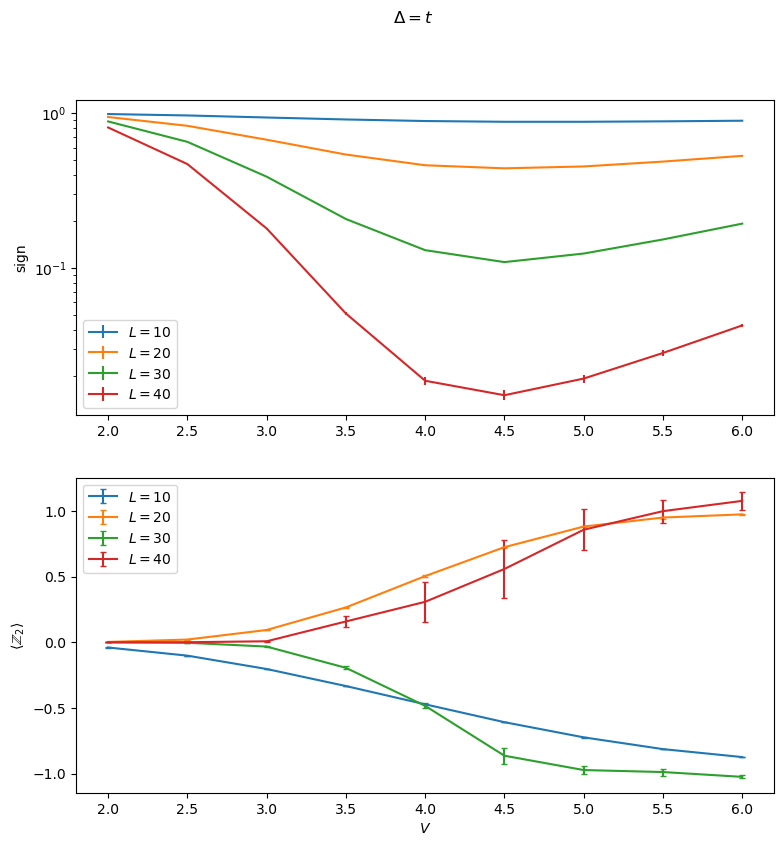

In [27]:
Vs = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

# Vs = np.arange(1.0, 7.5, 0.5)
# Ls = np.arange(8, 19, 2)

fig, axs = plt.subplots(2, 1, figsize=(9, 9))

for L in [10, 20, 30, 40]:
    signs = []
    signsStd = []
    z2PlusSigns = []
    z2PlusSignsStd = []
    z2MinusSigns = []
    z2MinusSignsStd = []
    for V in Vs:
        # print("L = {}, V = {}".format(L, V))
        # obs, params = getChainDataFromFile(L, V)
        # r = biningAndAnalysis(obs)
        r = data[(L, V)]
        signs.append(r["obsSign"][0])
        signsStd.append(r["obsSign"][1])
        z2PlusSigns.append(r["obsZ2"][0])
        z2PlusSignsStd.append(r["obsZ2"][1])

    axs[0].errorbar(Vs, signs, yerr=signsStd, label=r"$L = {}$".format(L))

    axs[1].errorbar(Vs, z2PlusSigns, yerr=z2PlusSignsStd, label=r"$L = {}$".format(L), capsize=2)

axs[0].set_ylabel(r"sign")
    # axs[0].set_ylim(0, 1.0)
axs[0].set_yscale("log")
axs[0].legend()
axs[1].set_ylabel(r"$\left<\mathbb{Z}_2 \right>$")
# axs[1].set_ylim(0, 1.0)
# axs[1].set_yscale("log")
axs[1].set_xlabel(r"$V$")
axs[1].legend()

fig.suptitle("$\Delta = t$")
plt.legend()
plt.show()



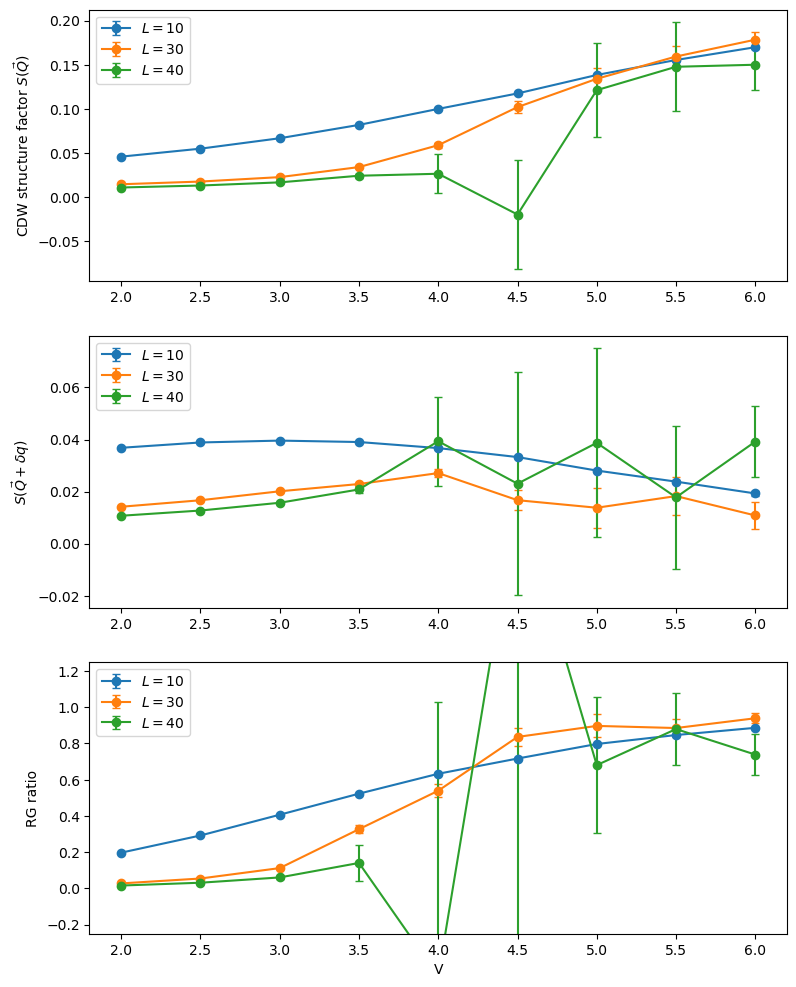

In [28]:
Vs = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

fig, axs = plt.subplots(3, 1, figsize=(9, 12))

cut = len(Vs)

# xs = np.arange(0.0, 7.0, 0.01)
# f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
# ys = np.array([f(x) for x in xs])
# axs[1].plot(xs, ys, label="exact")
# axs[2].plot(xs, -ys, label="exact")

for L in [10, 30, 40]:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    cdw = []
    cdwStd = []

    cdwq = []
    cdwqStd = []

    rgRatio = []
    rgRatioStd = []

    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        cdw.append(r["obsCDW"][0])
        cdwStd.append(r["obsCDW"][1])
        cdwq.append(r["obsCDWq"][0])
        cdwqStd.append(r["obsCDWq"][1])
        rgRatio.append(r["rgRatio"][0])
        rgRatioStd.append(r["rgRatio"][1])


    axs[0].errorbar(Vs, -np.array(cdw), yerr=cdwStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[1].errorbar(Vs, -np.array(cdwq), yerr=cdwqStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[2].errorbar(Vs, 1.0 - np.array(rgRatio), yerr=rgRatioStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    # if L in [8, 12, 16]:
    #     axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    
    # if L in [10, 14, 18]:
    #     axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    # axs[2].set_yscale("log")

axs[0].set_ylabel(r"CDW structure factor $S(\vec{Q})$")
axs[0].legend()

axs[1].set_ylabel(r"$S(\vec{Q} + \delta q)$")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"RG ratio")
axs[2].set_xlabel(r"V")
axs[2].set_ylim(-0.25, 1.25)
# axs[2].legend()
plt.legend()
plt.show()


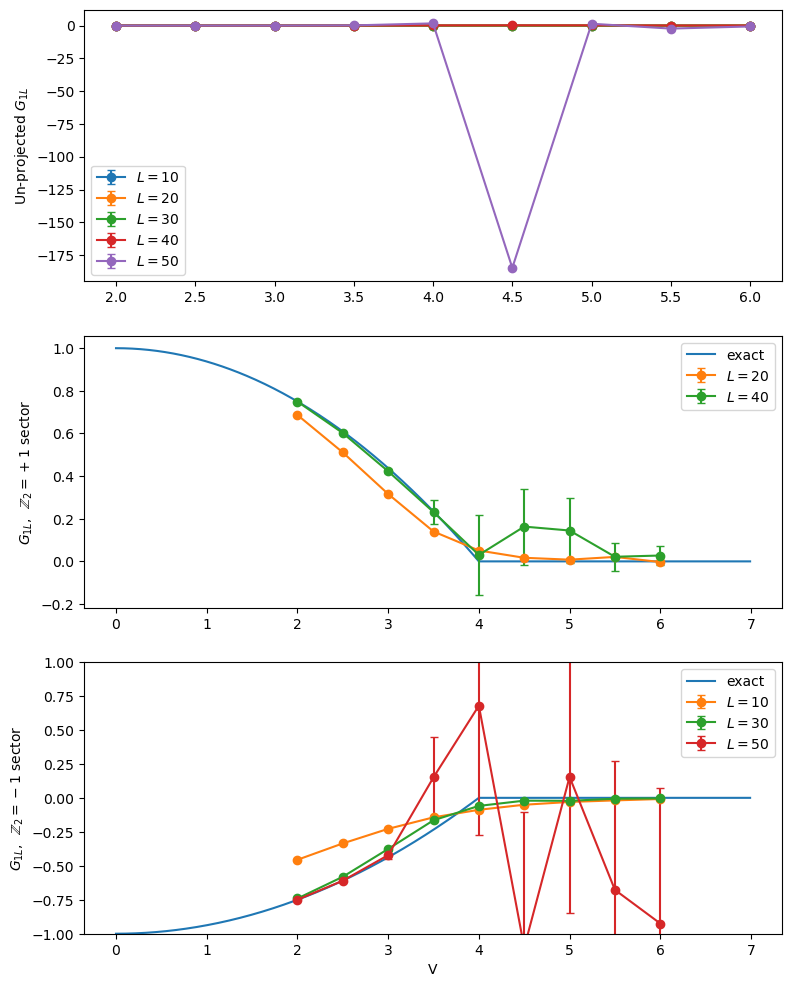

In [30]:
Vs = np.arange(2.0, 6.5, 0.5)

fig, axs = plt.subplots(3, 1, figsize=(9, 12))

cut = len(Vs)

xs = np.arange(0.0, 7.0, 0.01)
f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
ys = np.array([f(x) for x in xs])
axs[1].plot(xs, ys, label="exact")
axs[2].plot(xs, -ys, label="exact")

for L in [10, 20, 30, 40, 50]:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    eCorr = []
    eCorrStd = []

    eCorrZ2Plus = []
    eCorrZ2PlusStd = []
    eCorrZ2Minus = []
    eCorrZ2MinusStd = []
    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        eCorr.append(r["obsEdgeCorrelator"][0])
        eCorrStd.append(r["obsEdgeCorrelator"][1])
        eCorrZ2Plus.append(r["obsEdgeCorrelatorPlus"][0])
        eCorrZ2PlusStd.append(r["obsEdgeCorrelatorPlus"][1])
        eCorrZ2Minus.append(r["obsEdgeCorrelatorMinus"][0])
        eCorrZ2MinusStd.append(r["obsEdgeCorrelatorMinus"][1])

    
        
    eCorrStd = np.clip(np.abs(eCorrStd), 0, 1)
    eCorrZ2PlusStd = np.clip(np.abs(eCorrZ2PlusStd), 0, 1)
    eCorrZ2MinusStd = np.clip(np.abs(eCorrZ2MinusStd), 0, 1)


    axs[0].errorbar(Vs, eCorr, yerr=eCorrStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    if L in [20, 40]:
        axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), capsize=3, marker='o')
    
    if L in [10, 30, 50]:
        axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), capsize=3, marker='o')
    # axs[2].set_yscale("log")

axs[0].set_ylabel(r"Un-projected $G_{1L}$")
axs[0].legend()

axs[1].set_ylabel(r"$G_{1L}$,  $\mathbb{Z}_2=+1$ sector")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"$G_{1L}$,  $\mathbb{Z}_2=-1$ sector")
axs[2].set_xlabel(r"V")
axs[2].set_ylim(-1, 1.0)
axs[2].legend()
plt.legend()
plt.show()


# Ltau = L, V=3.5-4.8

In [7]:
with open('./data/data_L10-50_V3.5-4.8-0.1_len160k.pkl', 'rb') as f:
    data = pickle.load(f)

r = {}
for i in data:
    r[i[0]] = i[1]
data = r

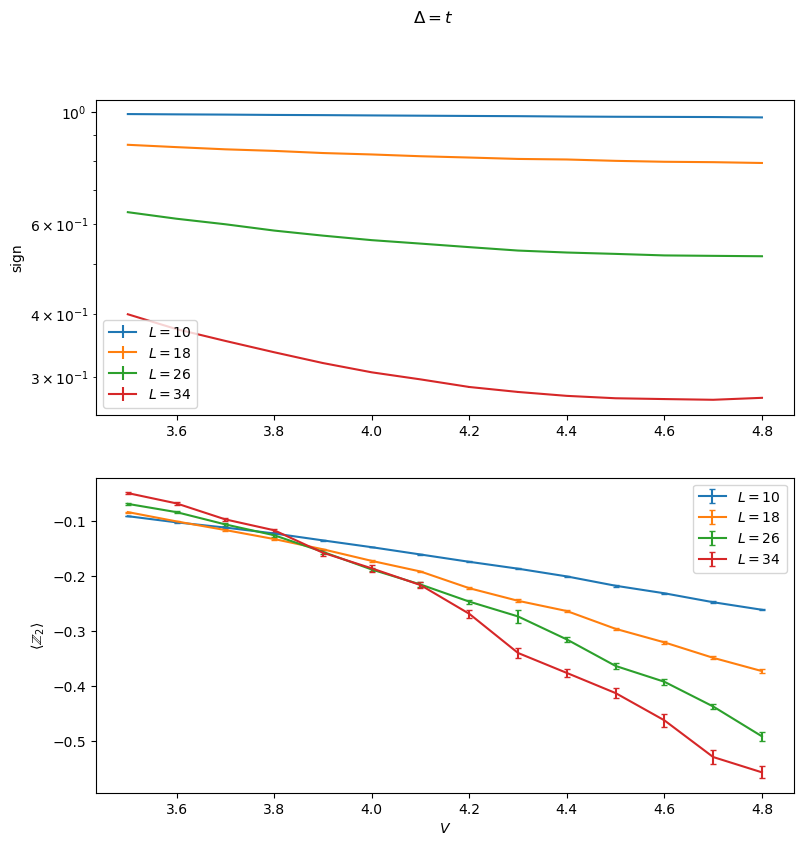

In [14]:
Vs = np.arange(3.5, 4.85, 0.1)

Ls = [10, 18, 26, 34]

# Vs = np.arange(1.0, 7.5, 0.5)
# Ls = np.arange(8, 19, 2)

fig, axs = plt.subplots(2, 1, figsize=(9, 9))

for L in Ls:
    signs = []
    signsStd = []
    z2PlusSigns = []
    z2PlusSignsStd = []
    z2MinusSigns = []
    z2MinusSignsStd = []
    for V in Vs:
        # print("L = {}, V = {}".format(L, V))
        # obs, params = getChainDataFromFile(L, V)
        # r = biningAndAnalysis(obs)
        r = data[(L, V)]
        signs.append(r["obsSign"][0])
        signsStd.append(r["obsSign"][1])
        z2PlusSigns.append(r["obsZ2"][0])
        z2PlusSignsStd.append(r["obsZ2"][1])

    axs[0].errorbar(Vs, signs, yerr=signsStd, label=r"$L = {}$".format(L))

    axs[1].errorbar(Vs, z2PlusSigns, yerr=z2PlusSignsStd, label=r"$L = {}$".format(L), capsize=2)

axs[0].set_ylabel(r"sign")
    # axs[0].set_ylim(0, 1.0)
axs[0].set_yscale("log")
axs[0].legend()
axs[1].set_ylabel(r"$\left<\mathbb{Z}_2 \right>$")
# axs[1].set_ylim(0, 1.0)
# axs[1].set_yscale("log")
axs[1].set_xlabel(r"$V$")
axs[1].legend()

fig.suptitle("$\Delta = t$")
plt.legend()
plt.show()



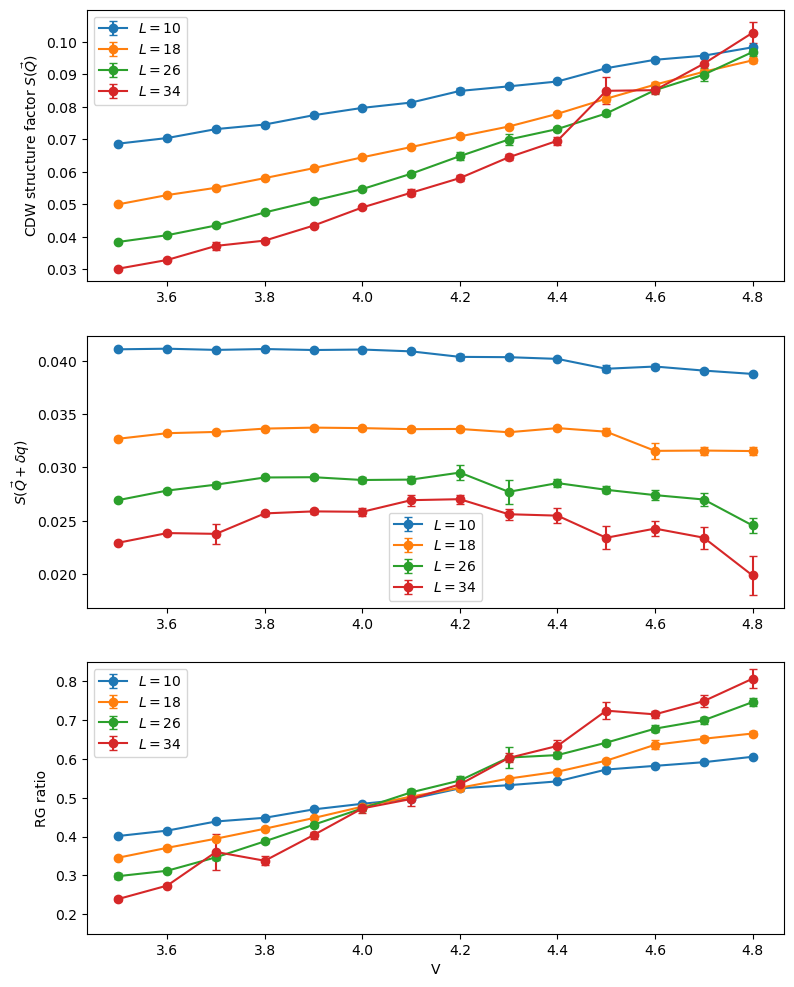

In [16]:
# Vs = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

fig, axs = plt.subplots(3, 1, figsize=(9, 12))

cut = len(Vs)

# xs = np.arange(0.0, 7.0, 0.01)
# f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
# ys = np.array([f(x) for x in xs])
# axs[1].plot(xs, ys, label="exact")
# axs[2].plot(xs, -ys, label="exact")

for L in Ls:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    cdw = []
    cdwStd = []

    cdwq = []
    cdwqStd = []

    rgRatio = []
    rgRatioStd = []

    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        cdw.append(r["obsCDW"][0])
        cdwStd.append(r["obsCDW"][1])
        cdwq.append(r["obsCDWq"][0])
        cdwqStd.append(r["obsCDWq"][1])
        rgRatio.append(r["rgRatio"][0])
        rgRatioStd.append(r["rgRatio"][1])


    axs[0].errorbar(Vs, -np.array(cdw), yerr=cdwStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[1].errorbar(Vs, -np.array(cdwq), yerr=cdwqStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    axs[2].errorbar(Vs, 1.0 - np.array(rgRatio), yerr=rgRatioStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    # if L in [8, 12, 16]:
    #     axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    
    # if L in [10, 14, 18]:
    #     axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), capsize=3)
    # axs[2].set_yscale("log")

axs[0].set_ylabel(r"CDW structure factor $S(\vec{Q})$")
axs[0].legend()

axs[1].set_ylabel(r"$S(\vec{Q} + \delta q)$")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"RG ratio")
axs[2].set_xlabel(r"V")
axs[2].set_ylim(0.15, 0.85)
# axs[2].legend()
plt.legend()
plt.show()
